# **6 - Fine-tuning para Classificação**

---

$\large \textbf{O que este capítulo aborda}$

* Introdução a diferentes abordagens de fine-tuning para LLMs
* Preparação de um conjunto de dados para classificação de texto
* Modificação de um LLM pré-treinado para fine-tuning
* Fine-tuning de um LLM para identificar mensagens de spam
* Avaliação da precisão de um classificador LLM após o fine-tuning
* Uso de um LLM ajustado para classificar novos dados

---

Até agora, codificamos a arquitetura de um LLM, o pré-treinamos e aprendemos a importar pesos pré-treinados de uma fonte externa, como a OpenAI, para o nosso modelo. Agora, colheremos os frutos do nosso trabalho ajustando o LLM para uma tarefa-alvo específica, como a classificação de texto. O exemplo concreto que examinaremos é a classificação de mensagens de texto como "spam" ou "não spam". A Figura 6.1 destaca as duas principais maneiras de fine-tuning de um LLM: fine-tuning para classificação (passo 8) e fine-tuning para seguir instruções (passo 9).

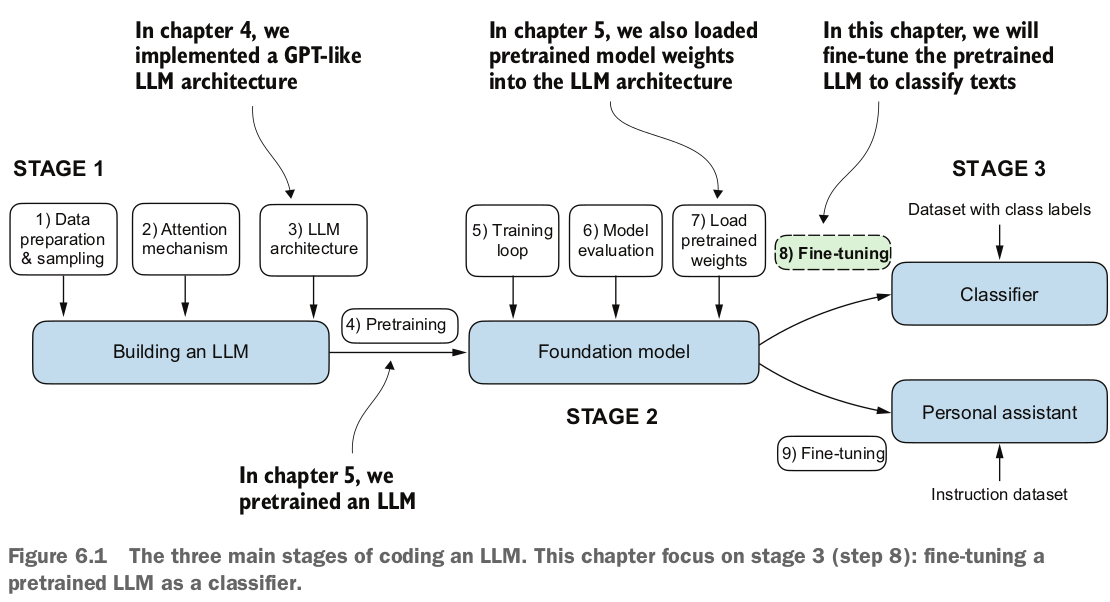

## **1 - Diferentes categorias de fine-tuning**

As formas mais comuns de ajustar modelos de linguagem são o **fine-tuning de instrução** e o **fine-tuning de classificação**. O **fine-tuning de instrução** envolve treinar um modelo de linguagem em um conjunto de tarefas usando instruções específicas para melhorar sua capacidade de entender e executar tarefas descritas em prompts de linguagem natural, conforme ilustrado na figura 6.2.

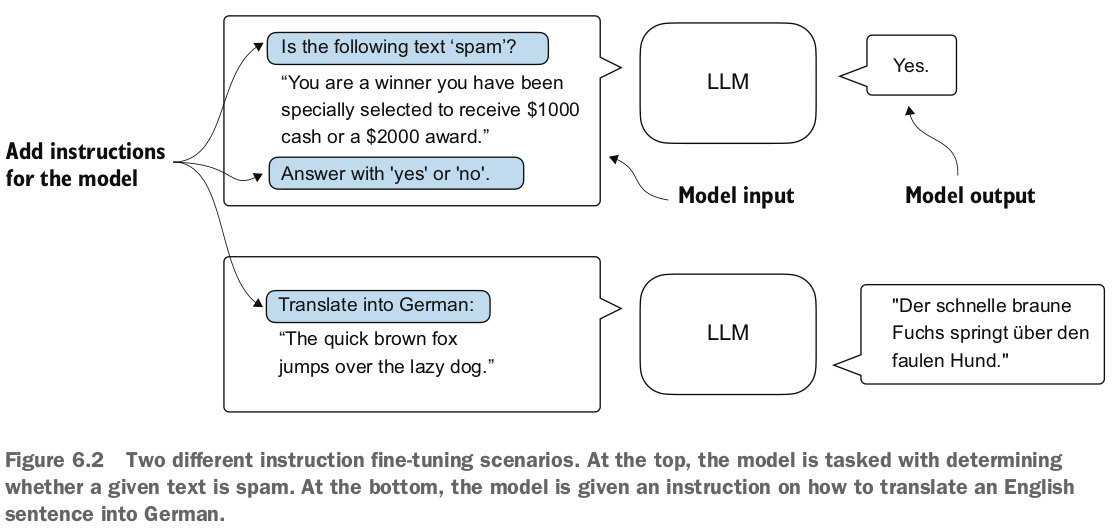

Em fine-tuning de classificação, um conceito com o qual você talvez já esteja familiarizado se tiver experiência em aprendizado de máquina, o modelo é treinado para reconhecer um conjunto específico de rótulos de classe, como "spam" e "não spam". Exemplos de tarefas de classificação que vão além dos LLMs e da filtragem de e-mail incluem: identificar diferentes espécies de plantas a partir de imagens; categorizar artigos de notícias em tópicos como esportes, política e tecnologia; e distinguir entre tumores benignos e malignos em imagens médicas.

O ponto-chave é que um modelo ajustado para classificação é restrito a prever classes que ele encontrou durante seu treinamento. Por exemplo, ele pode determinar se algo é "spam" ou "não spam", conforme ilustrado na figura 6.3, mas não pode dizer mais nada sobre o texto de entrada.

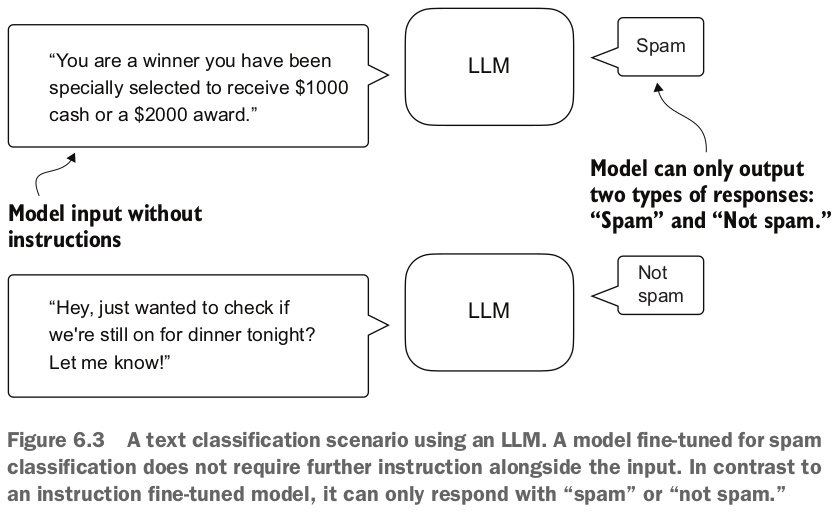

Em contraste com o modelo de fine-tuning de classificação mostrado na figura 6.3, um modelo de **fine-tuning de instrução** tipicamente consegue realizar uma gama mais ampla de tarefas. Podemos ver um modelo de fine-tuning de classificação como altamente especializado, e geralmente, é mais fácil desenvolver um modelo especializado do que um modelo generalista que funcione bem em diversas tarefas.

---

$\large \textbf{Escolhendo a abordagem correta}$

O fine-tuning de instrução melhora a capacidade de um modelo de entender e gerar respostas com base em instruções específicas do usuário. Ele é mais adequado para modelos que precisam lidar com uma variedade de tarefas baseadas em instruções complexas do usuário, melhorando a flexibilidade e a qualidade da interação. O fine-tuning de classificação é ideal para projetos que exigem a categorização precisa de dados em classes predefinidas, como análise de sentimento ou detecção de spam.

Embora o fine-tuning de instrução seja mais versátil, ele exige conjuntos de dados maiores e mais recursos computacionais para desenvolver modelos proficientes em várias tarefas. Em contrapartida, o fine-tuning de classificação requer menos dados e poder de computação, mas seu uso é restrito às classes específicas nas quais o modelo foi treinado.

---

## **2 - Preparando o conjunto de dados**

Iremos modificar e realizar o fine-tuning de classificação no modelo GPT que implementamos e pré-treinamos anteriormente. Começamos baixando e preparando o conjunto de dados, conforme destacado na figura 6.4. Para fornecer um exemplo intuitivo e útil de fine-tuning de classificação, trabalharemos com um conjunto de dados de mensagens de texto que consiste em mensagens de spam e não-spam.

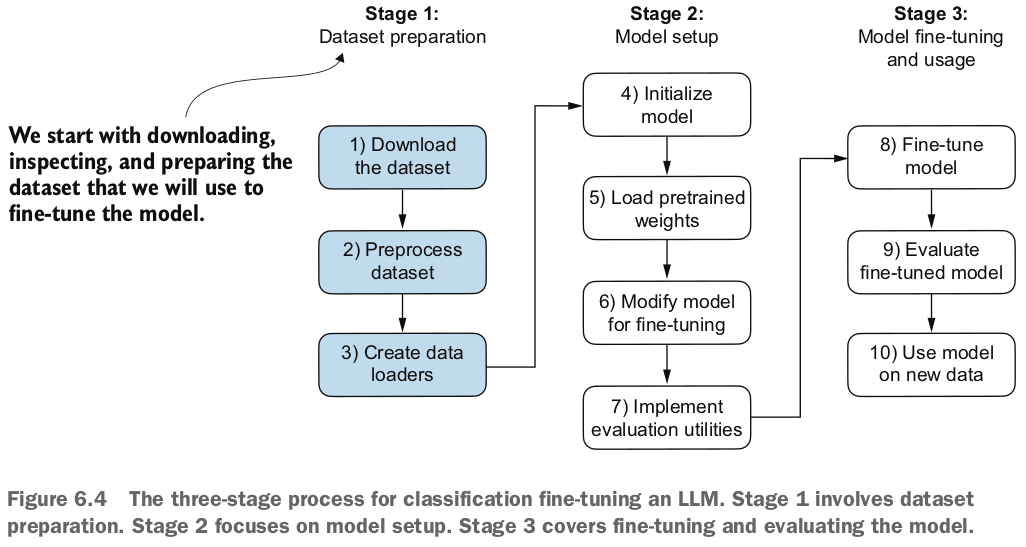

**NOTA:** Mensagens de texto são tipicamente enviadas por telefone, não por e-mail. No entanto, os mesmos passos também se aplicam à classificação de e-mail, e os leitores interessados podem encontrar links para conjuntos de dados de classificação de spam de e-mail no apêndice B.

O primeiro passo é baixar o conjunto de dados.

In [ ]:
import urllib.request # Importa o módulo urllib.request para abrir URLs e fazer requisições.
import zipfile # Importa o módulo zipfile para trabalhar com arquivos compactados (.zip).
import os # Importa o módulo os para interagir com o sistema operacional, como renomear arquivos.
from pathlib import Path # Importa a classe Path do módulo pathlib para manipular caminhos de arquivo de forma orientada a objetos.

# Define a URL de onde o arquivo zip será baixado.
url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
# Define o nome local para o arquivo zip que será baixado.
zip_path = "sms_spam_collection.zip"
# Define o nome do diretório onde o conteúdo do arquivo zip será extraído.
extracted_path = "sms_spam_collection"
# Define o caminho completo para o arquivo de dados extraído, renomeando-o para .tsv.
# Path(extracted_path) cria um objeto Path para o diretório de extração.
# / "SMSSpamCollection.tsv" junta o nome do diretório com o novo nome do arquivo usando o operador de divisão, que é sobrecarregado para este propósito em objetos Path.
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

# Define uma função para baixar e descompactar os dados de spam.
# A função recebe a URL, o caminho do arquivo zip, o diretório de extração e o caminho final do arquivo de dados como argumentos.
def download_and_unzip_spam_data(
    url, zip_path, extracted_path, data_file_path):
    # Verifica se o arquivo de dados final já existe no caminho especificado.
    if data_file_path.exists():
        # Se o arquivo existir, imprime uma mensagem informando que o download e a extração serão pulados.
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        # Retorna da função, encerrando sua execução.
        return

    # Abre a URL especificada para download.
    # 'with' garante que o recurso (a conexão URL) seja fechado automaticamente após o bloco de código.
    with urllib.request.urlopen(url) as response:
        # Abre um arquivo local no modo de escrita binária ('wb') para salvar o conteúdo baixado.
        # 'with' garante que o arquivo seja fechado automaticamente.
        with open(zip_path, "wb") as out_file:
            # Lê o conteúdo da resposta da URL e escreve no arquivo local.
            out_file.write(response.read())

    # Abre o arquivo zip baixado no modo de leitura ('r').
    # 'with' garante que o arquivo zip seja fechado automaticamente.
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        # Extrai todos os conteúdos do arquivo zip para o diretório especificado.
        zip_ref.extractall(extracted_path)

    # Define o caminho para o arquivo original extraído (sem a extensão .tsv).
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    # Renomeia o arquivo extraído original para o nome do arquivo de dados final (com a extensão .tsv).
    # Isso garante que o arquivo de dados tenha a extensão correta para ser lido como um arquivo TSV (valores separados por tabulação).
    os.rename(original_file_path, data_file_path)
    # Imprime uma mensagem confirmando que o arquivo foi baixado e salvo com o novo nome.
    print(f"File downloaded and saved as {data_file_path}")

# Chama a função download_and_unzip_spam_data com os parâmetros definidos anteriormente para iniciar o processo.
download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

File downloaded and saved as sms_spam_collection/SMSSpamCollection.tsv


Após a execução do código anterior, o conjunto de dados é salvo como um arquivo de texto separado por tabulações, `SMSSpamCollection.tsv`, na pasta `sms_spam_collection`. Podemos carregá-lo em um DataFrame do pandas da seguinte forma:

In [ ]:
import pandas as pd # Importa a biblioteca pandas, comumente usada para análise e manipulação de dados, e a renomeia para 'pd' para facilitar o uso.

# Carrega o conjunto de dados do arquivo TSV para um DataFrame do pandas.
df = pd.read_csv(
    data_file_path, # 'data_file_path' é o caminho para o arquivo 'SMSSpamCollection.tsv' que foi baixado e renomeado anteriormente. Este parâmetro especifica qual arquivo ler.
    sep="\t", # 'sep="\t"' indica que as colunas no arquivo estão separadas por tabulações (\t). O arquivo TSV (Tab Separated Values) usa tabulações como delimitador.
    header=None, # 'header=None' especifica que o arquivo não tem uma linha de cabeçalho. O pandas não usará a primeira linha como nomes de coluna.
    names=["Label", "Text"] # 'names=["Label", "Text"]' fornece uma lista de nomes para as colunas do DataFrame. Como 'header=None', esses nomes serão atribuídos às colunas na ordem em que aparecem no arquivo. A primeira coluna será nomeada "Label" e a segunda será nomeada "Text".
)

# Exibe o DataFrame completo.
# Ao executar uma célula que termina com o nome de uma variável contendo um DataFrame no Google Colab, o método display() é implicitamente chamado para mostrar o DataFrame de forma formatada.
df

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


Vamos examinar a distribuição dos rótulos de classe:

In [ ]:
print(df["Label"].value_counts())
print(df["Label"].value_counts(normalize = True)*100)

Label
ham     4825
spam     747
Name: count, dtype: int64
Label
ham     86.593683
spam    13.406317
Name: proportion, dtype: float64


Executando o código anterior, descobrimos que os dados contêm “ham” (ou seja, não spam) com muito mais frequência do que “spam”.

Para simplificar e porque preferimos um conjunto de dados pequeno (o que facilitará um fine-tuning mais rápido do LLM), escolhemos fazer uma subamostragem do conjunto de dados para incluir 747 instâncias de cada classe.

**NOTA:** Existem vários outros métodos para lidar com desequilíbrios de classe, mas eles estão além do escopo deste livro. Leitores interessados em explorar métodos para lidar com dados desequilibrados podem encontrar informações adicionais no apêndice B.

Podemos usar o código na listagem a seguir para fazer a subamostragem e criar um conjunto de dados balanceado.

In [ ]:
def create_balanced_dataset(df):
    # Conta o número de linhas onde a coluna "Label" é igual a "spam".
    # df["Label"] == "spam" cria uma série booleana (True/False) indicando se a linha é spam.
    # df[...] filtra o DataFrame original mantendo apenas as linhas onde a série booleana é True (ou seja, linhas de spam).
    # .shape[0] retorna o número de linhas do DataFrame filtrado.
    num_spam = df[df["Label"] == "spam"].shape[0]
    # Seleciona um subconjunto aleatório de linhas onde a coluna "Label" é igual a "ham" (não spam).
    # df[df["Label"] == "ham"] filtra o DataFrame original mantendo apenas as linhas "ham".
    # .sample(num_spam, random_state=123) seleciona aleatoriamente 'num_spam' linhas do subconjunto "ham".
    # 'num_spam' garante que o número de amostras "ham" seja igual ao número de amostras "spam".
    # 'random_state=123' garante que a amostragem seja reproduzível (se você executar o código novamente, obterá o mesmo subconjunto aleatório).
    ham_subset = df[df["Label"] == "ham"].sample(
        num_spam, random_state=123
    )
    # Concatena (combina) o subconjunto de linhas "ham" selecionado aleatoriamente com todas as linhas "spam" do DataFrame original.
    # pd.concat([...]) combina DataFrames ao longo de um eixo (por padrão, axis=0, que empilha as linhas).
    # O resultado é um novo DataFrame 'balanced_df' que contém um número igual de amostras "ham" e "spam".
    balanced_df = pd.concat([
        ham_subset, df[df["Label"] == "spam"]
    ])
    # Retorna o DataFrame balanceado.
    return balanced_df

# Chama a função create_balanced_dataset com o DataFrame original 'df' como entrada.
# O resultado (o DataFrame balanceado) é armazenado na variável 'balanced_df'.
balanced_df = create_balanced_dataset(df)
# Imprime a contagem de valores únicos na coluna "Label" do DataFrame balanceado.
# balanced_df["Label"] seleciona a coluna "Label" do DataFrame balanceado.
# .value_counts() conta a frequência de cada valor único na série resultante (neste caso, "ham" e "spam").
# Isso mostra a distribuição dos rótulos no conjunto de dados balanceado.
print(balanced_df["Label"].value_counts())
print(balanced_df["Label"].value_counts(normalize = True))

Label
ham     747
spam    747
Name: count, dtype: int64
Label
ham     0.5
spam    0.5
Name: proportion, dtype: float64


Depois de executar o código anterior para balancear o conjunto de dados, podemos ver que agora temos quantidades iguais de mensagens de spam e não spam.

Em seguida, convertemos os rótulos de classe “string” “ham” e “spam” em rótulos de classe inteiros 0 e 1, respectivamente:

In [ ]:
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

Esse processo é semelhante à conversão de texto em IDs de token. No entanto, em vez de usar o vocabulário do GPT, que consiste em mais de 50.000 palavras, estamos lidando com apenas dois IDs de token: 0 e 1.

Em seguida, criamos uma função `random_split` para dividir o conjunto de dados em três partes: 70% para treinamento, 10% para validação e 20% para teste. (Essas proporções são comuns em aprendizado de máquina para treinar, ajustar e avaliar modelos.)

In [ ]:
# Define uma função chamada random_split que recebe um DataFrame e duas frações como entrada.
# df: O DataFrame do pandas que será dividido.
# train_frac: A fração do DataFrame que será usada para o conjunto de treinamento (por exemplo, 0.7 para 70%).
# validation_frac: A fração do DataFrame que será usada para o conjunto de validação (por exemplo, 0.1 para 10%).
# A fração restante (1 - train_frac - validation_frac) será usada para o conjunto de teste.
def random_split(df, train_frac, validation_frac):
    # Embaralha o DataFrame aleatoriamente.
    # df.sample(frac=1, random_state=123): Cria uma amostra aleatória do DataFrame original.
    # frac=1 significa que a amostra incluirá 100% das linhas do DataFrame, efetivamente embaralhando-o.
    # random_state=123 define a semente para o gerador de números aleatórios. Isso garante que o embaralhamento seja o mesmo a cada execução, tornando a divisão reprodutível.
    # .reset_index(drop=True): Reseta o índice do DataFrame. O índice original é descartado (drop=True), e um novo índice sequencial (0, 1, 2, ...) é criado. Isso é importante após o embaralhamento para ter um índice contínuo.
    df = df.sample(
        frac=1, random_state=123
    ).reset_index(drop=True)

    # Calcula o índice final para o conjunto de treinamento.
    # len(df): Retorna o número total de linhas no DataFrame embaralhado.
    # len(df) * train_frac: Calcula o número de linhas destinadas ao treinamento (total de linhas multiplicado pela fração de treinamento).
    # int(...): Converte o resultado (que pode ser um float) para um número inteiro. Este será o ponto de corte para o conjunto de treinamento.
    train_end = int(len(df) * train_frac)
    # Calcula o índice final para o conjunto de validação.
    # train_end: Começa a partir do final do conjunto de treinamento.
    # int(len(df) * validation_frac): Calcula o número de linhas destinadas à validação.
    # O resultado é o índice onde o conjunto de validação termina e o conjunto de teste começa.
    validation_end = train_end + int(len(df) * validation_frac)

    # Divide o DataFrame embaralhado nos três subconjuntos.
    # train_df = df[:train_end]: Seleciona todas as linhas do início do DataFrame até o índice 'train_end' (não inclusivo). Este é o conjunto de treinamento.
    train_df = df[:train_end]
    # validation_df = df[train_end:validation_end]: Seleciona todas as linhas a partir do índice 'train_end' até o índice 'validation_end' (não inclusivo). Este é o conjunto de validação.
    validation_df = df[train_end:validation_end]
    # test_df = df[validation_end:]: Seleciona todas as linhas a partir do índice 'validation_end' até o final do DataFrame. Este é o conjunto de teste.
    test_df = df[validation_end:]

    # Retorna os três DataFrames resultantes (treinamento, validação e teste).
    # A função retorna uma tupla contendo os três DataFrames divididos.
    return train_df, validation_df, test_df

# Chama a função random_split para dividir o DataFrame balanceado (balanced_df).
# balanced_df: O DataFrame a ser dividido, que foi criado anteriormente e contém um número igual de amostras 'ham' e 'spam'.
# 0.7: Define a fração do conjunto de treinamento como 70%.
# 0.1: Define a fração do conjunto de validação como 10%.
# A fração do conjunto de teste será 1 - 0.7 - 0.1 = 0.2 (20%).
# Os três DataFrames retornados pela função são atribuídos às variáveis train_df, validation_df e test_df, respectivamente.
train_df, validation_df, test_df = random_split(
    balanced_df, 0.7, 0.1)

Vamos salvar o conjunto de dados como arquivos CSV (valores separados por vírgula) para que possamos reutilizá-los mais tarde:

In [ ]:
train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

Assim, baixamos, balanceamos e dividimos o conjunto de dados em subconjuntos de treinamento e avaliação. Agora, configuraremos os carregadores de dados do PyTorch que serão usados para treinar o modelo.

## **3 - Criando carregadores de dados**

Desenvolveremos carregadores de dados do PyTorch conceitualmente semelhantes aos que implementamos ao trabalhar com dados de texto. Anteriormente, utilizamos uma técnica de janela deslizante para gerar blocos de texto de tamanho uniforme, que depois agrupamos em lotes para um treinamento de modelo mais eficiente. No entanto, agora estamos trabalhando com um conjunto de dados de spam que contém mensagens de texto de comprimentos variados. Para agrupar essas mensagens, temos duas opções principais:

* Truncar todas as mensagens para o comprimento da mensagem mais curta no conjunto de dados ou no lote.
* Adicionar padding (preenchimento) a todas as mensagens até o comprimento da mensagem mais longa no conjunto de dados ou no lote.

A primeira opção é computacionalmente mais barata, mas pode resultar em uma perda significativa de informações se as mensagens mais curtas forem muito menores que a média ou as mensagens mais longas, potencialmente reduzindo o desempenho do modelo. Por isso, optamos pela segunda opção, que preserva o conteúdo inteiro de todas as mensagens.

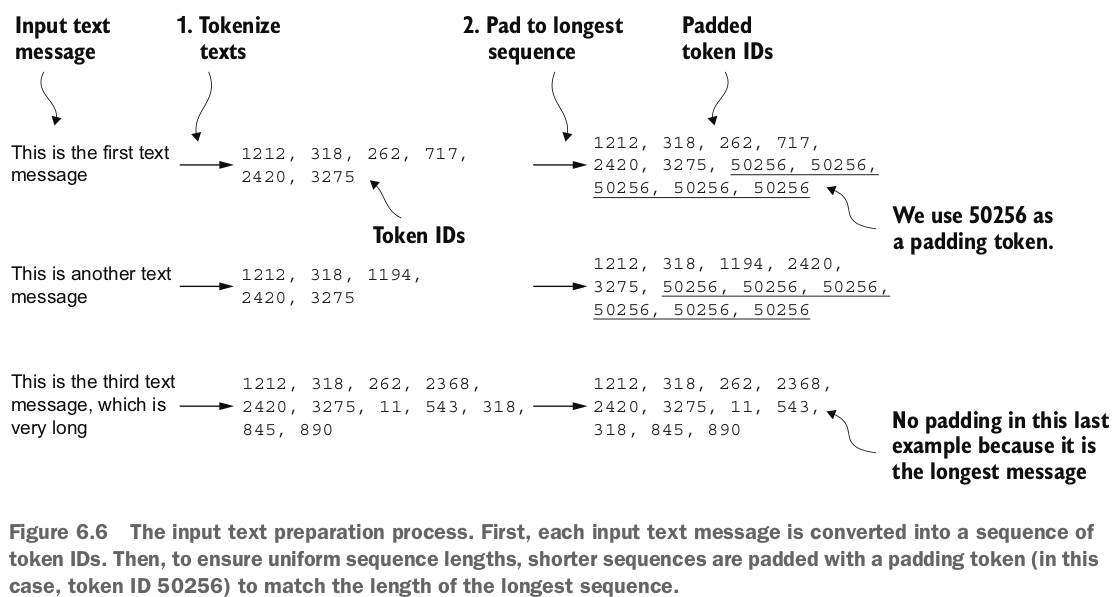

Para implementar o agrupamento em lotes, onde todas as mensagens são preenchidas até o comprimento da mensagem mais longa no conjunto de dados, usamos o token de preenchimento `<|endoftext|>`. Em vez de adicionar a string `<|endoftext|>` diretamente a cada mensagem de texto, podemos adicionar o ID de token correspondente a `<|endoftext|>` às mensagens de texto codificadas. Na figura 6.6, 50256 é o ID de token do token de preenchimento `<|endoftext|>`. Podemos verificar se o ID de token 50256 está correto usando o ***tokenizador GPT-2*** do pacote `tiktoken` que usamos anteriormente:

In [ ]:
import tiktoken # Importa a biblioteca tiktoken, que é usada para tokenização (converter texto em IDs numéricos) com modelos como o GPT-2.
tokenizer = tiktoken.get_encoding("gpt2") # Obtém a codificação (encoding) específica para o modelo "gpt2". Isso inicializa um objeto tokenizer configurado para funcionar com o vocabulário e as regras de tokenização do GPT-2.
# A codificação "gpt2" é uma codificação comum para muitos modelos da família GPT.
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"})) # Usa o objeto tokenizer para codificar a string especial "<|endoftext|>".
# tokenizer.encode(...) converte a string de texto em uma lista de IDs de token inteiros.
# "<|endoftext|>" é uma string que representa um token especial usado em alguns modelos de linguagem, frequentemente para indicar o fim de um texto.
# allowed_special={"<|endoftext|>"} é um parâmetro que especifica quais tokens especiais são permitidos durante a codificação.
# Neste caso, estamos explicitamente permitindo o token "<|endoftext|>". Se este token não fosse permitido, a codificação poderia tratá-lo de forma diferente ou gerar um erro, dependendo da configuração.
# O método print() exibe a lista de IDs de token resultantes no console. Espera-se que ele imprima o ID numérico correspondente ao token "<|endoftext|>".

[50256]


De fato, a execução do código anterior retorna `[50256]`.

Primeiro, precisamos implementar uma classe **`PyTorch Dataset`**, que especifica como os dados são carregados e processados antes de instanciarmos os carregadores de dados. Para isso, definimos a classe `SpamDataset`, que implementa os conceitos da figura 6.6. Essa classe `SpamDataset` lida com várias tarefas-chave: ela identifica a sequência mais longa no conjunto de dados de treinamento, codifica as mensagens de texto e garante que todas as outras sequências sejam preenchidas com um *token de preenchimento* para corresponder ao comprimento da sequência mais longa.

In [ ]:
import torch # Importa a biblioteca PyTorch, fundamental para a construção e treinamento de modelos de aprendizado de máquina, incluindo redes neurais.
from torch.utils.data import Dataset # Importa a classe base Dataset do módulo torch.utils.data. Classes de Dataset são a base para carregar dados personalizados no PyTorch.

# Define a classe SpamDataset que herda de torch.utils.data.Dataset.
# Esta classe customizada é responsável por carregar, pré-processar e fornecer os dados para o treinamento do modelo.
class SpamDataset(Dataset):
    # O método __init__ é o construtor da classe, chamado quando um objeto SpamDataset é criado.
    # Ele inicializa os atributos da instância.
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        # self.data: Atributo para armazenar o DataFrame do pandas carregado do arquivo CSV.
        # pd.read_csv(csv_file): Lê o arquivo CSV especificado por 'csv_file' e retorna um DataFrame.
        self.data = pd.read_csv(csv_file)
        # self.encoded_texts: Atributo para armazenar as mensagens de texto codificadas.
        # [tokenizer.encode(text) for text in self.data["Text"]]: Usa uma list comprehension para iterar sobre cada texto na coluna "Text" do DataFrame.
        # tokenizer.encode(text): Para cada texto, o tokenizador (passado como argumento) o converte em uma lista de IDs de token (inteiros).
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["Text"]
        ]

        # Verifica se um comprimento máximo de sequência foi especificado.
        if max_length is None:
            # Se max_length for None, calcula o comprimento da sequência codificada mais longa no conjunto de dados.
            self.max_length = self._longest_encoded_length()
        else:
            # Caso contrário, usa o valor de max_length fornecido.
            self.max_length = max_length

            # Trunca as sequências codificadas para o comprimento máximo especificado, se necessário.
            self.encoded_texts = [
                encoded_text[:self.max_length] # Pega os primeiros 'self.max_length' elementos da lista de IDs de token.
                for encoded_text in self.encoded_texts
            ]

        # Adiciona padding (preenchimento) às sequências codificadas para que todas tenham o mesmo comprimento (max_length).
        self.encoded_texts = [
            encoded_text + [pad_token_id] * # Concatena a lista de IDs de token com uma lista de IDs de padding.
            (self.max_length - len(encoded_text)) # Calcula quantos tokens de padding são necessários (diferença entre o comprimento máximo e o comprimento atual da sequência).
            for encoded_text in self.encoded_texts # Itera sobre cada sequência codificada.
        ]

    # O método __getitem__ é obrigatório para classes que herdam de Dataset.
    # Ele retorna um item (uma amostra) do conjunto de dados dado um índice.
    def __getitem__(self, index):
        # encoded: Obtém a sequência codificada (lista de IDs de token) no índice especificado.
        encoded = self.encoded_texts[index]
        # label: Obtém o rótulo (spam ou ham, convertido para 0 ou 1) no índice especificado do DataFrame original.
        label = self.data.iloc[index]['Label']
        # Retorna uma tupla contendo:
        # torch.tensor(encoded, dtype=torch.long): Converte a lista de IDs de token em um tensor PyTorch do tipo long (inteiro de 64 bits).
        # torch.tensor(label, dtype=torch.long): Converte o rótulo em um tensor PyTorch do tipo long.
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )

    # O método __len__ é obrigatório para classes que herdam de Dataset.
    # Ele retorna o número total de amostras no conjunto de dados.
    def __len__(self):
        # Retorna o número de linhas no DataFrame (que corresponde ao número de mensagens).
        return len(self.data)

    # Método auxiliar privado para encontrar o comprimento da sequência codificada mais longa.
    def _longest_encoded_length(self):
        # Inicializa max_length com 0.
        max_length = 0
        # Itera sobre todas as sequências codificadas.
        for encoded_text in self.encoded_texts:
            # Obtém o comprimento da sequência codificada atual.
            encoded_length = len(encoded_text)
            # Se o comprimento atual for maior que o max_length registrado, atualiza max_length.
            if encoded_length > max_length:
                max_length = encoded_length
        # Retorna o comprimento máximo encontrado.
        return max_length

A classe `SpamDataset` carrega dados dos arquivos CSV que criamos anteriormente, tokeniza o texto usando o tokenizador GPT-2 do `tiktoken`, e nos permite preencher (`pad`) ou truncar (`truncate`) as sequências para um comprimento uniforme, determinado pela sequência mais longa ou por um comprimento máximo predefinido. Isso garante que cada tensor de entrada tenha o mesmo tamanho, o que é necessário para criar os lotes no carregador de dados de treinamento que implementaremos a seguir:

In [ ]:
# Instancia a classe SpamDataset para o conjunto de dados de treinamento.
train_dataset = SpamDataset(
    # csv_file="train.csv": Especifica o caminho para o arquivo CSV que contém os dados de treinamento.
    # Este arquivo foi criado e salvo anteriormente no passo de preparação dos dados.
    csv_file="train.csv",
    # max_length=None: Define o comprimento máximo das sequências codificadas.
    # Como está definido como None, a classe SpamDataset calculará automaticamente o comprimento da sequência mais longa no conjunto de dados de treinamento
    # e usará esse valor para preencher (padding) as sequências mais curtas.
    max_length=None,
    # tokenizer=tokenizer: Passa o objeto tokenizer inicializado anteriormente (com a codificação "gpt2") para a classe SpamDataset.
    # Este tokenizer será usado dentro da classe para converter as mensagens de texto em IDs de token numéricos.
    tokenizer=tokenizer
)

O comprimento da sequência mais longa é armazenado no atributo `max_length` do conjunto de dados. Se você estiver curioso para ver o número de tokens na sequência mais longa, pode usar o seguinte código:

In [ ]:
print(train_dataset.max_length)

120


O código retorna 120, mostrando que a sequência mais longa não contém mais que 120 tokens, um comprimento comum para mensagens de texto. O modelo consegue lidar com sequências de até 1.024 tokens, dado o seu limite de comprimento de contexto. Se o seu conjunto de dados incluir textos mais longos, você pode passar `max_length=1024` ao criar o conjunto de dados de treinamento no código anterior para garantir que os dados não excedam o comprimento de entrada (contexto) suportado pelo modelo.

Em seguida, preenchemos os conjuntos de validação e teste para que correspondam ao comprimento da sequência de treinamento mais longa. É importante ressaltar que quaisquer amostras dos conjuntos de validação e teste que excedam o comprimento do exemplo de treinamento mais longo são truncadas usando `encoded_text[:self.max_length]` no código da classe `SpamDataset` que definimos anteriormente. Esse truncamento é opcional; você pode definir `max_length=None` tanto para os conjuntos de validação quanto para os de teste, desde que não haja sequências que excedam 1.024 tokens nesses conjuntos:

In [ ]:
val_dataset = SpamDataset(
    csv_file="validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

test_dataset = SpamDataset(
    csv_file="test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

---

$\large \textbf{Exercício 6.1 Aumentando o comprimento do contexto}$

Preencha as entradas com o número máximo de tokens que o modelo suporta e observe como isso afeta o desempenho preditivo.

---

Usando os conjuntos de dados como entrada, podemos instanciar os carregadores de dados de forma semelhante a quando estávamos trabalhando com dados de texto. No entanto, neste caso, os alvos representam rótulos de classe em vez dos próximos tokens no texto. Por exemplo, se escolhermos um tamanho de lote de 8, cada lote consistirá em oito exemplos de treinamento de 120 de comprimento e o rótulo de classe correspondente de cada exemplo, conforme ilustrado na figura 6.7.

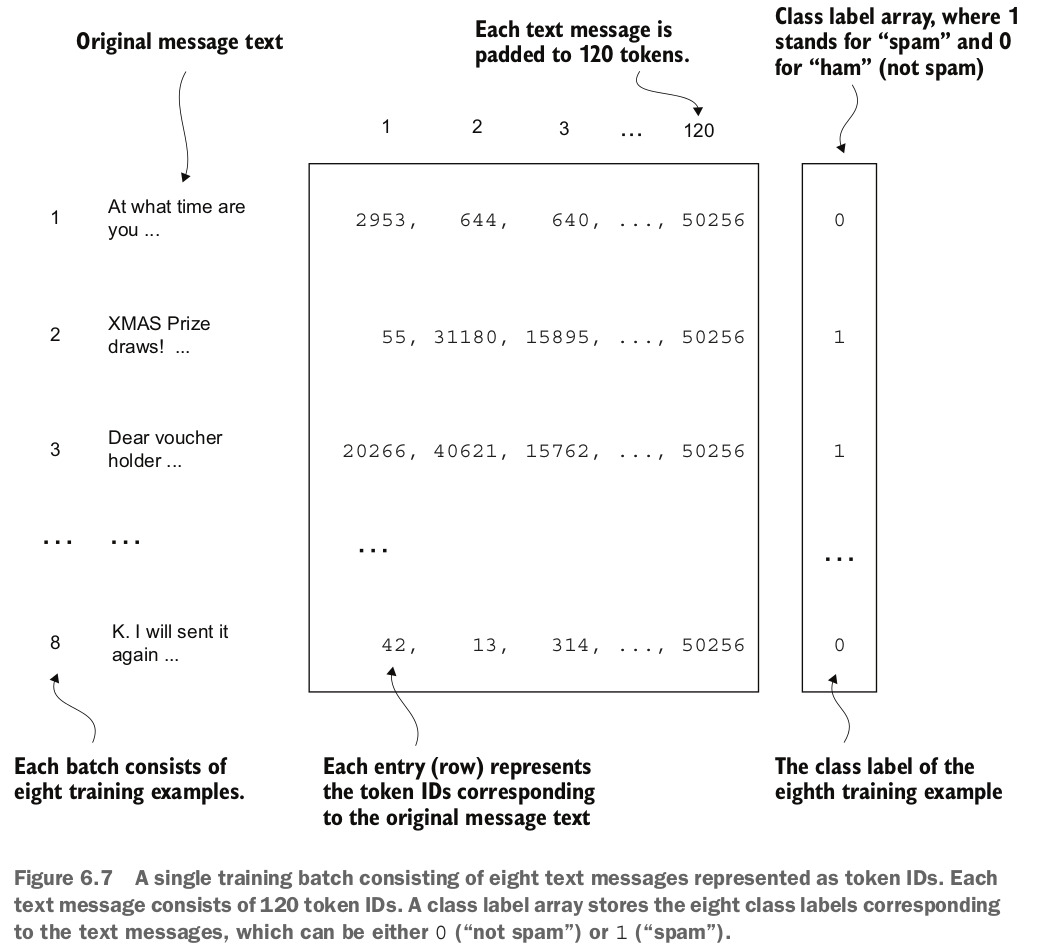

O código na listagem a seguir cria os carregadores de dados de treinamento, validação e conjunto de testes que carregam as mensagens de texto e rótulos em lotes de tamanho 8.

In [ ]:
from torch.utils.data import DataLoader # Importa a classe DataLoader do módulo torch.utils.data. DataLoader é usado para iterar sobre um Dataset e carregar dados em lotes para o treinamento.

num_workers = 0 # Define o número de subprocessos a serem usados para carregamento de dados. 0 significa que os dados serão carregados no processo principal. Esta configuração garante compatibilidade com a maioria dos computadores, mas usar um número maior pode acelerar o carregamento de dados em sistemas com múltiplos núcleos.
batch_size = 8 # Define o tamanho do lote (batch size). Cada lote conterá 'batch_size' amostras de dados. Lotes maiores podem acelerar o treinamento, mas requerem mais memória.
torch.manual_seed(123) # Define a semente para o gerador de números aleatórios do PyTorch. Isso garante que a aleatoriedade (como a ordem dos dados se shuffle=True) seja a mesma a cada execução, tornando os resultados reproduzíveis.

# Cria o DataLoader para o conjunto de dados de treinamento.
train_loader = DataLoader(
    dataset=train_dataset, # Especifica o objeto Dataset a ser carregado (o SpamDataset de treinamento).
    batch_size=batch_size, # Define o tamanho do lote para este DataLoader, usando a variável batch_size definida anteriormente.
    shuffle=True, # Se True, os dados serão embaralhados a cada época (passagem completa pelo conjunto de treinamento). Isso ajuda a evitar que o modelo aprenda a ordem dos dados.
    num_workers=num_workers, # Define o número de subprocessos para carregamento de dados, usando a variável num_workers definida anteriormente.
    drop_last=True, # Se True, a última lote incompleto (se o número total de amostras não for divisível por batch_size) será descartado. Isso garante que todos os lotes tenham o mesmo tamanho, o que pode ser útil para algumas arquiteturas de modelo.
)

# Cria o DataLoader para o conjunto de dados de validação.
val_loader = DataLoader(
    dataset=val_dataset, # Especifica o objeto Dataset a ser carregado (o SpamDataset de validação).
    batch_size=batch_size, # Define o tamanho do lote.
    shuffle=False, # Para validação, geralmente não embaralhamos os dados, pois a ordem não afeta a avaliação e a reprodução da avaliação é mais fácil.
    num_workers=num_workers, # Define o número de subprocessos.
    drop_last=False, # Para validação e teste, geralmente não descartamos o último lote incompleto para garantir que todas as amostras sejam avaliadas.
)

# Cria o DataLoader para o conjunto de dados de teste.
test_loader = DataLoader(
    dataset=test_dataset, # Especifica o objeto Dataset a ser carregado (o SpamDataset de teste).
    batch_size=batch_size, # Define o tamanho do lote.
    num_workers=num_workers, # Define o número de subprocessos.
    drop_last=False, # Para teste, não descartamos o último lote incompleto.
)

Para garantir que os carregadores de dados estejam funcionando e, de fato, retornando lotes do tamanho esperado, iteramos sobre o carregador de treinamento e, em seguida, imprimimos as dimensões do tensor do último lote:

In [ ]:
# Itera sobre o train_loader (carregador de dados de treinamento).
# A cada iteração, train_loader retorna um lote de dados de entrada (input_batch) e um lote de rótulos alvo (target_batch).
# O loop 'for' percorrerá todos os lotes disponíveis no conjunto de treinamento.
for input_batch, target_batch in train_loader:
    # 'pass' é uma instrução nula em Python.
    # Neste contexto, o loop está apenas iterando sobre os lotes sem fazer nada com eles.
    # O objetivo é simplesmente carregar o último lote na memória para que suas dimensões possam ser verificadas após o loop.
    pass
# Após o loop terminar (ou seja, após processar o último lote), o input_batch e o target_batch ainda contêm os dados do último lote.

# Imprime as dimensões (shape) do tensor do lote de entrada.
# input_batch.shape retorna uma tupla que representa as dimensões do tensor input_batch.
# Espera-se que a primeira dimensão seja o tamanho do lote (batch_size) e a segunda dimensão seja o comprimento da sequência preenchida (max_length).
print("Input batch dimensions:", input_batch.shape)
# Imprime as dimensões (shape) do tensor do lote de rótulos alvo.
# target_batch.shape retorna uma tupla que representa as dimensões do tensor target_batch.
# Espera-se que a única dimensão seja o tamanho do lote (batch_size), pois cada amostra tem um único rótulo (0 ou 1).
print("Label batch dimensions", target_batch.shape)

Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])


Como podemos ver, os lotes de entrada consistem em oito exemplos de treinamento com 120 tokens cada, como esperado. O tensor de rótulo armazena os rótulos de classe correspondentes aos oito exemplos de treinamento.

Por fim, para ter uma ideia do tamanho do conjunto de dados, vamos imprimir o número total de lotes em cada conjunto de dados:

In [ ]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

130 training batches
19 validation batches
38 test batches


Agora que preparamos os dados, precisamos preparar o modelo para o fine-tuning.

## **4 - Inicializando um modelo com pesos pré-treinados**

Precisamos preparar o modelo para o ajuste fino (fine-tuning) de classificação, a fim de identificar mensagens de spam. Começamos inicializando nosso modelo pré-treinado, conforme destacado na figura 6.8.

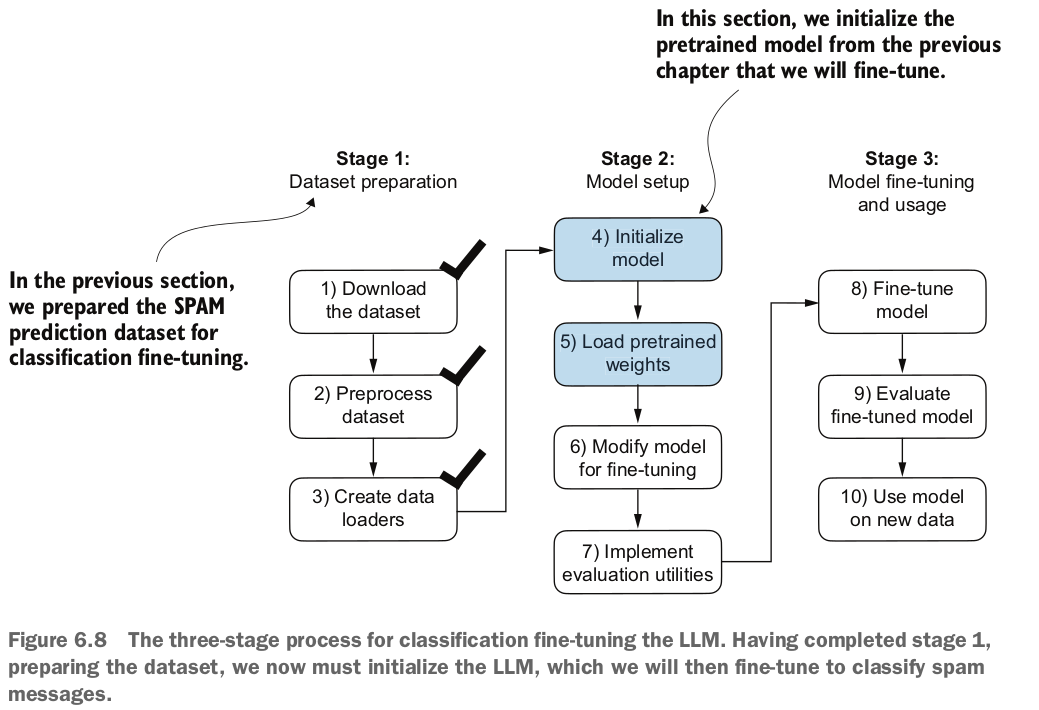

Para iniciar o processo de preparação do modelo, empregamos as mesmas configurações que usamos para pré-treinar dados não rotulados:

In [ ]:
CHOOSE_MODEL = "gpt2-small (124M)" # Define qual tamanho de modelo GPT-2 será utilizado. A string inclui o nome e o número aproximado de parâmetros.
INPUT_PROMPT = "Every effort moves" # Define um prompt de entrada de exemplo. Embora não seja usado diretamente neste trecho de código, é relevante para a demonstração do LLM.

BASE_CONFIG = {
    "vocab_size": 50257, # Tamanho do vocabulário: Número total de tokens únicos que o modelo pode entender. Para GPT-2, é 50257.
    "context_length": 1024, # Comprimento do contexto: O número máximo de tokens que o modelo pode processar em uma única entrada.
    "drop_rate": 0.0, # Taxa de dropout: A fração de neurônios que são aleatoriamente definidos como zero durante o treinamento para evitar overfitting. 0.0 significa que o dropout está desativado neste caso.
    "qkv_bias": True # Viés de query-key-value: Um parâmetro booleano que indica se os mecanismos de atenção (query, key, value) incluem um termo de viés. True significa que sim.
}

model_configs = {
    # Dicionário que armazena configurações específicas para diferentes tamanhos de modelos GPT-2.
    # Cada chave é o nome do modelo e cada valor é um dicionário com as dimensões do embedding (emb_dim),
    # o número de camadas de transformador (n_layers) e o número de cabeças de atenção (n_heads).
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

# Atualiza o dicionário BASE_CONFIG com as configurações específicas do modelo escolhido (CHOOSE_MODEL).
# BASE_CONFIG.update(...) adiciona ou sobrescreve pares chave-valor de model_configs[CHOOSE_MODEL] em BASE_CONFIG.
# Isso mescla as configurações base com as configurações específicas do tamanho do modelo selecionado.
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

Em seguida, importamos a função `download_and_load_gpt2` do arquivo `gpt_download.py` e reutilizamos a classe `GPTModel` e a função `load_weights_into_gpt` do pré-treinamento (veja o capítulo 5) para carregar os pesos baixados no modelo GPT.

In [ ]:
# Precisamos baixar o pacote abaixo, ele permite usar funções dos capítulos anteriores
# A descrição desse pacote está no link abaixo
# https://github.com/rasbt/LLMs-from-scratch/tree/main/pkg/llms_from_scratch
!pip install llms-from-scratch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.3/83.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 106.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 64.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59.8 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 83.1 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


Baixamos o módulo Python `gpt_download.py` diretamente do repositório online do capítulo 5:

In [ ]:
# Importa o módulo `urllib.request` da biblioteca padrão do Python.
# Este módulo é usado para trabalhar com URLs e baixar dados da internet.
import urllib.request
# Define a URL do arquivo que queremos baixar.
# Esta URL aponta para o arquivo `gpt_download.py` no repositório GitHub do livro "LLMs from Scratch".
url = (
    "https://raw.githubusercontent.com/rasbt/"
    "LLMs-from-scratch/main/ch05/"
    "01_main-chapter-code/gpt_download.py"
)
# Extrai o nome do arquivo da URL.
# url.split('/') divide a string da URL em uma lista de substrings usando '/' como delimitador.
# [-1] seleciona o último elemento da lista, que é o nome do arquivo (`gpt_download.py`).
filename = url.split('/')[-1]
# Baixa o arquivo da URL especificada e o salva com o nome de arquivo extraído.
# urllib.request.urlretrieve(url, filename):
# - url: A URL do recurso a ser baixado.
# - filename: O caminho local onde o recurso baixado será salvo.
# Esta função baixa o conteúdo da URL e o escreve diretamente no arquivo especificado.
urllib.request.urlretrieve(url, filename)

('gpt_download.py', <http.client.HTTPMessage at 0x78164226a750>)

Com os pacotes baixados no ambiente, podemos dar prosseguimento:

In [ ]:
from gpt_download import download_and_load_gpt2 # Importa a função download_and_load_gpt2 do arquivo gpt_download.py. Esta função é responsável por baixar os pesos pré-treinados do modelo GPT-2 de um repositório.
from llms_from_scratch.ch04 import GPTModel # Importa a classe GPTModel do arquivo chapter04.py.
from llms_from_scratch.ch05 import load_weights_into_gpt # Importa a função load_weights_into_gpt do arquivo chapter05.py.
# GPTModel é a definição da arquitetura do modelo GPT que foi implementada anteriormente (no capítulo 5).
# load_weights_into_gpt é uma função auxiliar para carregar os pesos baixados na arquitetura do modelo GPT.

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")") # Extrai o tamanho numérico do modelo da string CHOOSE_MODEL.
# CHOOSE_MODEL.split(" ") divide a string (ex: "gpt2-small (124M)") em uma lista de substrings ['gpt2-small', '(124M)'].
# [-1] seleciona o último elemento da lista ('(124M)').
# .lstrip("(") remove o parêntese esquerdo do início da string ('124M)').
# .rstrip(")") remove o parêntese direito do final da string ('124M').
# O resultado é a string numérica que representa o tamanho do modelo (ex: "124M").

settings, params = download_and_load_gpt2(
    model_size=model_size, models_dir="gpt2"
) # Chama a função download_and_load_gpt2 para baixar os pesos pré-treinados do modelo especificado.
# model_size=model_size: Passa o tamanho do modelo extraído para a função, indicando qual versão do GPT-2 baixar.
# models_dir="gpt2": Especifica o diretório onde os pesos baixados serão salvos ("gpt2").
# A função retorna duas variáveis: 'settings' (configurações do modelo baixado) e 'params' (os pesos do modelo baixado).

model = GPTModel(BASE_CONFIG) # Instancia a classe GPTModel (cria um objeto modelo).
# BASE_CONFIG: Passa o dicionário de configurações base definido anteriormente para o construtor da classe GPTModel.
# Isso inicializa a arquitetura do modelo com as dimensões corretas (tamanho do vocabulário, comprimento do contexto, dimensões do embedding, número de camadas, número de cabeças).

#load_weights_into_gpt(model, params) # Chama a função load_weights_into_gpt para carregar os pesos baixados ('params') na instância do modelo ('model').
# Isso popula o modelo com os pesos aprendidos durante o pré-treinamento.

#model.eval() # Define o modelo para o modo de avaliação (evaluation mode).
# No modo de avaliação, certas camadas (como dropout e normalização em lote) se comportam de forma diferente (por exemplo, o dropout é desativado).
# É importante definir o modelo para eval() antes de fazer inferências ou avaliações para obter resultados consistentes.

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 177kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 2.39MiB/s]
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 120kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [01:46<00:00, 4.69MiB/s]
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 8.24MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:00<00:00, 1.53MiB/s]
vocab.bpe: 100%|██████████| 456k/456k [00:00<00:00, 1.69MiB/s]


Depois de carregar os pesos do modelo no `GPTModel`, reutilizamos a função utilitária de geração de texto dos capítulos 4 e 5 para garantir que o modelo gere um texto coerente:

In [ ]:
from llms_from_scratch.ch04 import generate_text_simple # Importa a função generate_text_simple do arquivo chapter04.py. Esta função é usada para gerar texto sequencialmente a partir de um modelo.
from llms_from_scratch.ch05 import text_to_token_ids, token_ids_to_text # Importa as funções text_to_token_ids e token_ids_to_text do arquivo chapter05.py.
# text_to_token_ids: Converte uma string de texto em uma lista de IDs de token usando um tokenizador.
# token_ids_to_text: Converte uma lista de IDs de token de volta para uma string de texto usando um tokenizador.

text_1 = "Every effort moves you" # Define uma string de texto inicial (prompt) que será usada para iniciar a geração de texto.
token_ids = generate_text_simple(
    model=model, # model=model: Passa a instância do modelo GPT carregado para a função de geração de texto.
    idx=text_to_token_ids(text_1, tokenizer), # idx=...: Fornece os IDs de token do texto inicial como entrada para a função de geração. text_to_token_ids() converte a string text_1 em IDs de token.
    max_new_tokens=15, # max_new_tokens=15: Especifica o número máximo de novos tokens que a função generate_text_simple deve gerar após o prompt inicial.
    context_size=BASE_CONFIG["context_length"] # context_size=...: Define o tamanho do contexto que o modelo usará para gerar o próximo token. Usa o valor definido em BASE_CONFIG.
) # A função generate_text_simple retorna uma lista de IDs de token, incluindo os do prompt inicial e os novos tokens gerados. Esta lista é armazenada na variável token_ids.

print(token_ids_to_text(token_ids, tokenizer)) # Converte a lista final de IDs de token de volta para uma string de texto usando a função token_ids_to_text e imprime o resultado.

Every effort moves you forward.

The first step is to understand the importance of your work


A saída mostra que o modelo gera texto coerente, o que indica que os pesos do modelo foram carregados corretamente.

Antes de começarmos a ajustar o modelo como um classificador de spam, vamos ver se o modelo já classifica mensagens de spam, solicitando instruções:

In [ ]:
# Define a string de texto 'text_2'. Esta string serve como um prompt para o modelo.
# O prompt é formulado como uma pergunta de classificação de spam, pedindo ao modelo para responder 'yes' ou 'no'.
# Inclui um exemplo de texto que é tipicamente considerado spam.
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially'"
    " selected to receive $1000 cash or a $2000 award.'"
)

# Chama a função generate_text_simple para gerar texto usando o modelo.
# Esta função é usada para demonstrar o comportamento do modelo antes do fine-tuning de classificação.
token_ids = generate_text_simple(
    model=model, # model=model: Passa a instância do modelo GPT (carregado com pesos pré-treinados, mas antes do fine-tuning de classificação) para a função de geração.
                  # Este é o modelo que tentará responder à pergunta no prompt.
    idx=text_to_token_ids(text_2, tokenizer), # idx=...: Fornece os IDs de token do texto inicial (o prompt 'text_2') como entrada para a função de geração.
                                              # text_to_token_ids(text_2, tokenizer) converte a string text_2 em uma lista de IDs de token usando o tokenizador GPT-2.
                                              # Este é o ponto de partida para a geração de texto do modelo.
    max_new_tokens=23, # max_new_tokens=23: Especifica o número máximo de novos tokens que a função generate_text_simple deve gerar após o prompt inicial.
                       # O modelo tentará gerar até 23 tokens adicionais para completar a resposta ao prompt.
    context_size=BASE_CONFIG["context_length"] # context_size=...: Define o tamanho da janela de contexto que o modelo usará para gerar o próximo token.
                                               # Usa o valor definido em BASE_CONFIG (que é 1024 para o modelo 'gpt2-small'). O modelo considerará os últimos 'context_size' tokens para prever o próximo.
) # A função generate_text_simple retorna uma lista de IDs de token, que inclui os IDs do prompt inicial e os novos tokens gerados. Esta lista é armazenada na variável token_ids.

# Converte a lista final de IDs de token de volta para uma string de texto e a imprime.
# token_ids_to_text(token_ids, tokenizer): Usa a função token_ids_to_text para decodificar a lista de IDs de token de volta para uma string legível usando o tokenizador.
# print(...) exibe a string de texto resultante no console.
# A saída mostra o texto completo gerado pelo modelo, começando com o prompt e seguido pelos tokens gerados.
# A interpretação da saída (como no markdown seguinte) revelará se o modelo, sem fine-tuning de classificação, consegue seguir a instrução de responder 'yes' ou 'no' e classificar o texto como spam.
print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially' selected to receive $1000 cash or a $2000 award.'

The following text 'spam'? Answer with 'yes' or 'no': 'You are a winner


Com base na saída, é evidente que o modelo está com dificuldades para seguir as instruções. Esse resultado é esperado, pois ele passou apenas por um pré-treinamento e não por um ajuste fino de instruções. Portanto, vamos preparar o modelo para o ajuste fino de classificação.

## **5 - Adicionando um cabeçalho de classificação**

Precisamos modificar o LLM pré-treinado para prepará-lo para o ajuste fino de classificação. Para fazer isso, substituímos a camada de saída original, que mapeia a representação oculta para um vocabulário de 50.257, por uma camada de saída menor que mapeia para duas classes: 0 ("não spam") e 1 ("spam"), como mostrado na figura 6.9. Usamos o mesmo modelo de antes, exceto que substituímos a camada de saída.

---

$\large \textbf{Nós da camada de saída}$

Poderíamos usar tecnicamente um único nó de saída, já que estamos lidando com uma tarefa de classificação binária. No entanto, isso exigiria a modificação da função de perda, como discutido em "Losses Learned—Optimizing Negative Log-Likelihood and Cross-Entropy in PyTorch" (https://mng.bz/NRZ2). Portanto, escolhemos uma abordagem mais geral, onde o número de nós de saída corresponde ao número de classes. Por exemplo, para um problema de três classes, como classificar notícias como "Tecnologia", "Esportes" ou "Política", usaríamos três nós de saída, e assim por diante.

---

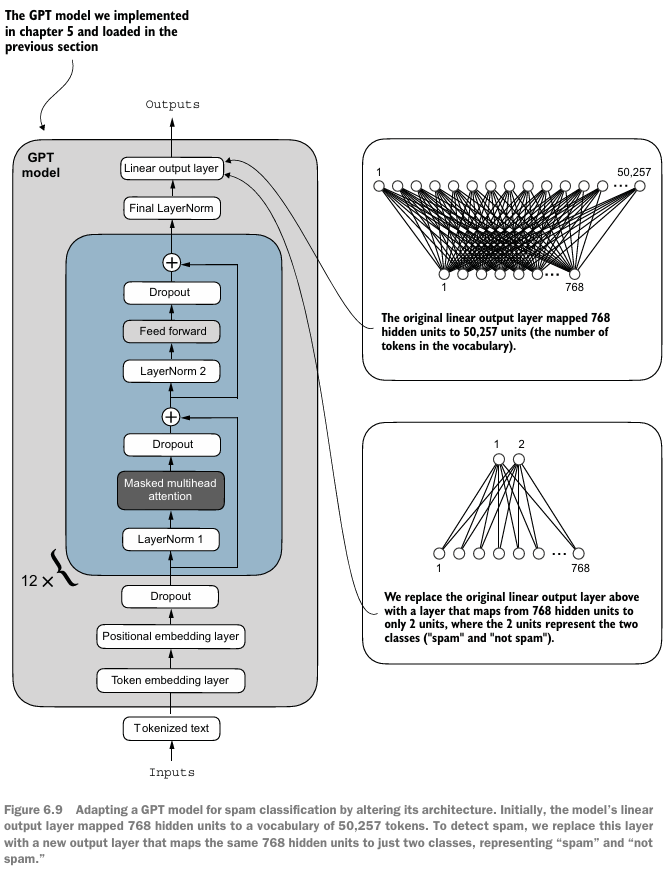

Antes de tentarmos a modificação mostrada na figura 6.9, vamos imprimir a arquitetura do modelo via `print(model)`:

In [ ]:
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768,

Esta saída apresenta de forma organizada a arquitetura que definimos no capítulo 4. Conforme discutido anteriormente, o `GPTModel` consiste em camadas de embedding seguidas por 12 blocos idênticos de transformadores (apenas o último bloco é mostrado para brevidade), seguidos por uma `LayerNorm` final e a camada de saída, `out_head`.

Em seguida, substituímos o `out_head` por uma nova camada de saída (veja a figura 6.9) que iremos ajustar.

---

$\large \textbf{Ajuste Fino de Camadas Selecionadas vs. Todas as Camadas}$

Como começamos com um modelo pré-treinado, não é necessário fazer o ajuste fino de todas as camadas do modelo. Em modelos de linguagem baseados em redes neurais, as camadas inferiores geralmente capturam estruturas e semânticas básicas da linguagem aplicáveis a uma ampla gama de tarefas e conjuntos de dados. Por isso, fazer o ajuste fino apenas das últimas camadas (ou seja, as camadas próximas à saída), que são mais específicas para padrões linguísticos sutis e características de tarefas específicas, é frequentemente suficiente para adaptar o modelo a novas tarefas. Um efeito colateral positivo é que é computacionalmente mais eficiente ajustar apenas um pequeno número de camadas. Leitores interessados podem encontrar mais informações, incluindo experimentos, sobre quais camadas ajustar no apêndice B.

---

Para preparar o modelo para o ajuste fino da classificação, primeiro congelamos o modelo, o que significa que tornamos todas as camadas não treináveis:

In [ ]:
# Itera sobre todos os parâmetros (pesos e vieses) do modelo.
# model.parameters() retorna um iterador sobre todos os tensores de parâmetros no modelo.
for param in model.parameters():
    # Define o atributo 'requires_grad' de cada parâmetro como False.
    # Quando requires_grad é False, o PyTorch não calculará gradientes para este parâmetro durante a retropropagação (backpropagation).
    # Isso efetivamente "congela" o parâmetro, impedindo que ele seja atualizado durante o treinamento.
    # Ao definir requires_grad = False para todos os parâmetros inicialmente, estamos congelando todo o modelo pré-treinado.
    # Posteriormente, selecionaremos explicitamente quais camadas (parâmetros) queremos descongelar e treinar (fine-tune).
    param.requires_grad = False

Em seguida, substituímos a camada de saída (`model.out_head`), que originalmente mapeia as entradas da camada para 50.257 dimensões, o tamanho do vocabulário (veja a figura 6.9).

In [ ]:
# Define a semente para o gerador de números aleatórios do PyTorch.
# Isso garante que a inicialização aleatória dos pesos da nova camada de saída seja a mesma a cada execução,
# tornando os resultados reproduzíveis.
torch.manual_seed(123)
# Define o número de classes para o problema de classificação.
# Neste caso, estamos classificando em "spam" (1) e "não spam" (0), então há 2 classes.
num_classes = 2
# Substitui a camada de saída existente do modelo (model.out_head) por uma nova camada Linear (totalmente conectada).
# torch.nn.Linear é uma classe no PyTorch que implementa uma camada linear (ou densa) em uma rede neural.
model.out_head = torch.nn.Linear(
    # in_features=BASE_CONFIG["emb_dim"]: Define o número de características de entrada para a nova camada Linear.
    # BASE_CONFIG["emb_dim"] armazena a dimensão do embedding do modelo (768 para o modelo 'gpt2-small').
    # Isso significa que a camada de entrada da nova camada Linear espera tensores com 768 características.
    # A camada anterior (LayerNorm final) produz saídas com esta dimensão.
    in_features=BASE_CONFIG["emb_dim"],
    # out_features=num_classes: Define o número de características de saída para a nova camada Linear.
    # num_classes é 2, então a camada de saída produzirá um tensor de dimensão 2.
    # Cada uma dessas duas saídas corresponderá a uma das classes (0 para não spam, 1 para spam).
    # Durante o treinamento, o modelo aprenderá a mapear a representação oculta final do texto de entrada para essas duas saídas,
    # indicando a probabilidade de a entrada pertencer a cada classe.
    out_features=num_classes
)

Para manter o código mais genérico, usamos `BASE_CONFIG["emb_dim"]`, que é igual a 768 no modelo "gpt2-small (124M)". Dessa forma, podemos usar o mesmo código para trabalhar com as variantes maiores do modelo GPT-2.

Esta nova camada de saída `model.out_head` tem seu atributo `requires_grad` definido como `True` por padrão, o que significa que é a única camada no modelo que será atualizada durante o treinamento. Tecnicamente, treinar apenas a camada de saída que acabamos de adicionar é suficiente. No entanto, como foi descoberto em experimentos, o ajuste fino de camadas adicionais pode melhorar notavelmente o desempenho preditivo do modelo (para mais detalhes, consulte o apêndice B). Também configuramos o último bloco do transformador e o módulo final `LayerNorm`, que conecta este bloco à camada de saída, para serem treináveis, conforme ilustrado na figura 6.10.

Para tornar o `LayerNorm` final e o último bloco do transformador treináveis, definimos seus respectivos `requires_grad` como `True`:

In [ ]:
# Itera sobre os parâmetros do último bloco do transformador do modelo.
# model.trf_blocks acessa a lista de blocos de transformador no modelo.
# [-1] seleciona o último bloco da lista.
# .parameters() retorna um iterador sobre todos os tensores de parâmetros dentro deste bloco de transformador.
for param in model.trf_blocks[-1].parameters():
    # Define o atributo 'requires_grad' de cada parâmetro neste bloco para True.
    # Isso "descongela" esses parâmetros, permitindo que seus gradientes sejam calculados durante a retropropagação.
    # Consequentemente, esses parâmetros serão atualizados durante o treinamento (fine-tuning).
    # Ao fazer isso, estamos permitindo que o último bloco do transformador seja ajustado aos dados de classificação.
    param.requires_grad = True
# Itera sobre os parâmetros da camada de normalização final do modelo.
# model.final_norm acessa a camada LayerNorm final do modelo.
# .parameters() retorna um iterador sobre todos os tensores de parâmetros dentro desta camada LayerNorm.
for param in model.final_norm.parameters():
    # Define o atributo 'requires_grad' de cada parâmetro nesta camada para True.
    # Isso "descongela" esses parâmetros, permitindo que sejam atualizados durante o treinamento (fine-tuning).
    # A camada LayerNorm final está entre o último bloco do transformador e a nova camada de saída de classificação,
    # e ajustá-la junto com o último bloco e a camada de saída pode ajudar a melhorar o desempenho.
    param.requires_grad = True

---

$\large \textbf{Exercício 6.2: Ajustando todo o modelo}$

Em vez de ajustar apenas o bloco final do transformador, ajuste todo o modelo e avalie o efeito no desempenho preditivo.

---

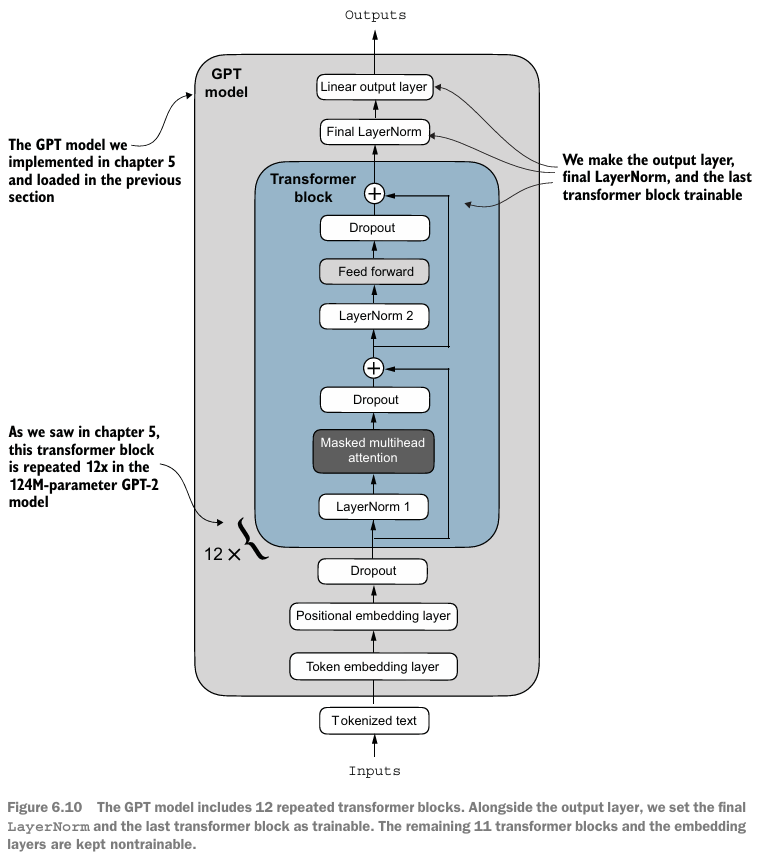

Mesmo que tenhamos adicionado uma nova camada de saída e marcado determinadas camadas como treináveis ​​ou não treináveis, ainda podemos usar este modelo da mesma forma que fizemos anteriormente. Por exemplo, podemos fornecer a ele um texto de exemplo idêntico ao texto de exemplo usado anteriormente:

In [ ]:
# Define uma string de texto de exemplo para usar como entrada para o modelo.
# Esta string será tokenizada e convertida em IDs numéricos.
inputs = tokenizer.encode("Do you have time")

# Converte a lista de IDs de token (retornada por tokenizer.encode) em um tensor PyTorch.
# torch.tensor(inputs): Cria um tensor a partir da lista 'inputs'. Por padrão, será um tensor 1D.
# .unsqueeze(0): Adiciona uma nova dimensão na posição 0 (o início).
# Isso é necessário porque os modelos PyTorch geralmente esperam entradas em formato de lote, mesmo que haja apenas uma amostra.
# O formato esperado é (tamanho do lote, comprimento da sequência).
# Ao adicionar a dimensão extra, o tensor se torna (1, número de tokens), simulando um lote de tamanho 1.
inputs = torch.tensor(inputs).unsqueeze(0)

# Imprime o tensor de entrada resultante.
# Isso mostra os IDs de token numéricos que representam a string "Do you have time".
print("Inputs:", inputs)

# Imprime as dimensões (shape) do tensor de entrada.
# .shape retorna uma tupla que representa as dimensões do tensor.
# Espera-se que a saída seja torch.Size([1, X]), onde X é o número de tokens na string "Do you have time".
print("Inputs dimensions:", inputs.shape)

Inputs: tensor([[5211,  345,  423,  640]])
Inputs dimensions: torch.Size([1, 4])


A saída de impressão mostra que o código anterior codifica as entradas em um tensor que consiste em quatro tokens de entrada. Então, podemos passar os IDs de token codificados para o modelo como de costume:

In [ ]:
# O bloco 'with torch.no_grad():' é um gerenciador de contexto no PyTorch.
# Ele desabilita o cálculo de gradientes para todas as operações dentro deste bloco.
# Isso é útil durante a inferência ou avaliação, pois não precisamos calcular gradientes
# para atualizar os pesos do modelo. Desabilitar o cálculo de gradientes economiza
# memória e acelera as operações.
with torch.no_grad():
    # Passa os inputs processados para o modelo.
    # model(inputs) chama o método forward do objeto model.
    # O modelo processa o tensor de entrada 'inputs' e retorna a saída.
    # Neste ponto, como a camada de saída (out_head) foi modificada para ter 2 features de saída,
    # a saída 'outputs' será um tensor com dimensões (tamanho do lote, comprimento da sequência, número de classes).
    # Para a entrada de exemplo "Do you have time", que tem 4 tokens e um tamanho de lote de 1,
    # a dimensão esperada para 'outputs' será (1, 4, 2).
    outputs = model(inputs)

# Imprime o tensor de saída gerado pelo modelo.
# A saída será um tensor PyTorch contendo os scores ou logits brutos para cada classe (0 e 1)
# para cada token na sequência de entrada.
# Por exemplo, para a entrada "Do you have time", haverá scores para 'ham' e 'spam'
# para cada um dos 4 tokens.
print("Outputs:\n", outputs)

# Imprime as dimensões (shape) do tensor de saída.
# outputs.shape retorna uma tupla que representa as dimensões do tensor 'outputs'.
# Como explicado anteriormente, para este caso, a dimensão esperada é (tamanho do lote, comprimento da sequência, número de classes).
print("Outputs dimensions:", outputs.shape)

Outputs:
 tensor([[[-1.5854,  0.9904],
         [-3.7235,  7.4548],
         [-2.2661,  6.6049],
         [-3.5983,  3.9902]]])
Outputs dimensions: torch.Size([1, 4, 2])


Uma entrada similar teria produzido anteriormente um tensor de saída com as dimensões $[1, 4, 50257]$, onde $50257$ representa o tamanho do vocabulário. O número de linhas de saída corresponde ao número de tokens de entrada (neste caso, quatro). Contudo, a dimensão de embedding de cada saída (o número de colunas) agora é 2 em vez de 50.257, já que a camada de saída do modelo foi substituída.

Lembre-se que o objetivo é ajustar o modelo para que ele retorne um rótulo de classe que indique se uma entrada é "spam" ou "não spam". Não é necessário ajustar todas as quatro linhas de saída; em vez disso, você pode se concentrar em um único token de saída. Em particular, a atenção será voltada para a última linha, que corresponde ao último token de saída, como exibido na figura 6.11.

Para extrair o último token de saída do tensor, use o seguinte código:

In [ ]:
# Imprime o último token de saída do tensor de outputs.
# outputs[:, -1, :]: Esta é uma operação de indexação e fatiamento em um tensor PyTorch.
# outputs: Refere-se ao tensor de saída gerado pelo modelo, que tem a forma (tamanho do lote, comprimento da sequência, número de classes).
# : no primeiro índice: Seleciona todas as amostras no lote (todos os lotes).
# -1 no segundo índice: Seleciona o último elemento na dimensão do comprimento da sequência. Em PyTorch e Python, -1 indexa o último item de uma lista ou tensor.
# : no terceiro índice: Seleciona todas as características na dimensão do número de classes (neste caso, ambas as classes, 0 e 1).
# O resultado desta operação é um tensor que contém os scores de saída para o último token de cada sequência no lote, para todas as classes.
# Para um lote de tamanho 1 (como no exemplo anterior), o resultado será um tensor com as dimensões (1, 2), onde 1 é o tamanho do lote e 2 são os scores para as classes 'ham' e 'spam'.
print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[-3.5983,  3.9902]])


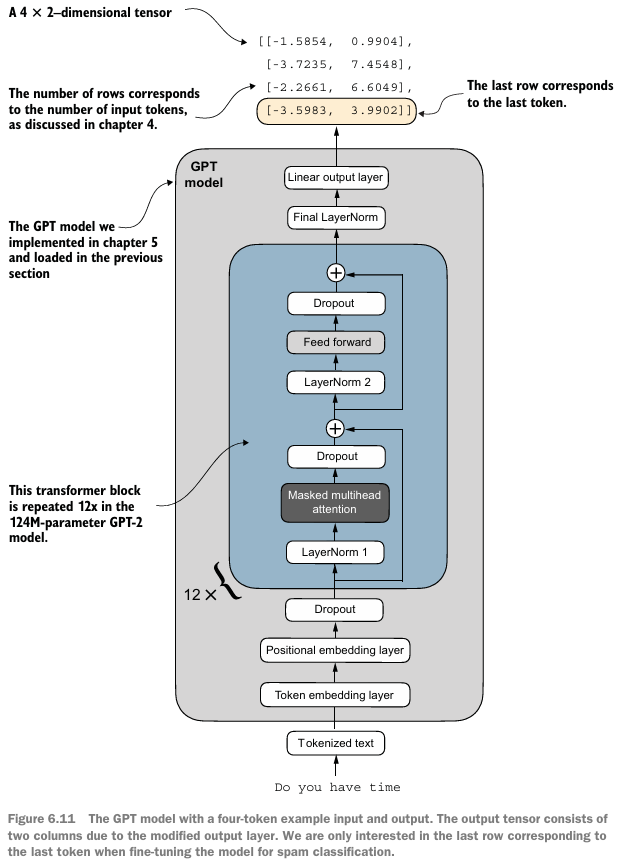

Ainda precisamos converter os valores em uma previsão de rótulo de classe. Mas, primeiro, vamos entender por que estamos particularmente interessados apenas no último token de saída.

Já exploramos o mecanismo de atenção, que estabelece uma relação entre cada token de entrada e todos os outros tokens de entrada, e o conceito de uma máscara de atenção causal, comumente usada em modelos do tipo GPT. Essa máscara restringe o foco de um token à sua posição atual e às posições anteriores, garantindo que cada token possa ser influenciado apenas por ele mesmo e pelos tokens que o precedem, como ilustrado na figura 6.12.

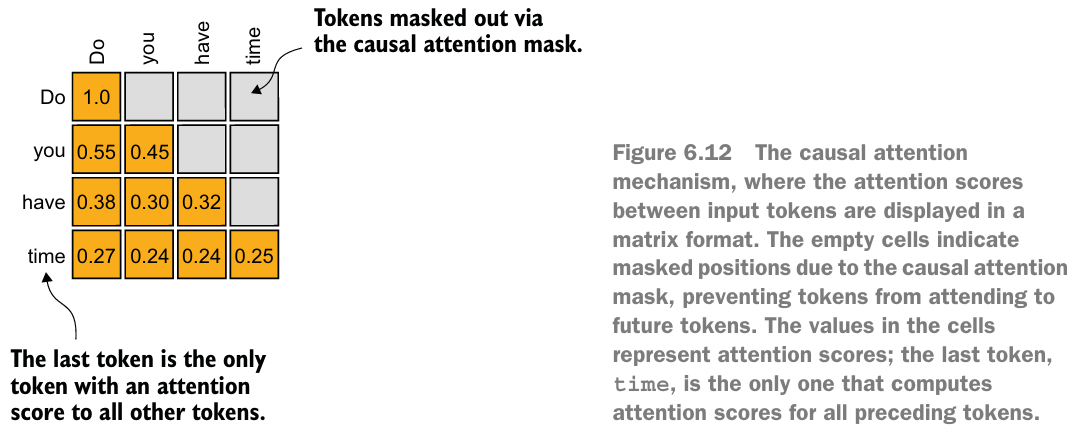

Dada a configuração da máscara de atenção causal na figura 6.12, o último token em uma sequência acumula a maior parte das informações, pois é o único token com acesso aos dados de todos os tokens anteriores. Portanto, na tarefa de classificação de spam, o foco é no último token durante o processo de ajuste fino.

Agora, o modelo está pronto para transformar o último token em previsões de rótulos de classe e para calcular sua precisão de previsão inicial. Em seguida, será feito o ajuste fino do modelo para a tarefa de classificação de spam.

---

$\large \textbf{Exercício 6.3 Ajuste Fino do Primeiro vs. Último Token}$

Tente fazer o ajuste fino do primeiro token de saída. Observe as mudanças no desempenho preditivo em comparação com o ajuste fino do último token de saída.

---

## **6 - Calculando a perda e a precisão da classificação**

Resta apenas uma pequena tarefa antes de ajustarmos o modelo: precisamos implementar as funções de avaliação do modelo usadas durante o ajuste fino, como ilustrado na figura 6.13.

Antes de implementar as utilidades de avaliação, vamos discutir brevemente como convertemos as saídas do modelo em previsões de rótulos de classe. Anteriormente, nós calculamos a ID do token do próximo token gerado pelo LLM convertendo as 50.257 saídas em probabilidades através da função `softmax` e, em seguida, retornando a posição da maior probabilidade através da função `argmax`. Adotamos a mesma abordagem aqui para calcular se o modelo produz uma previsão de "spam" ou "não spam" para uma determinada entrada, como mostrado na figura 6.14. A única diferença é que trabalhamos com saídas de 2 dimensões em vez de saídas de 50.257 dimensões.

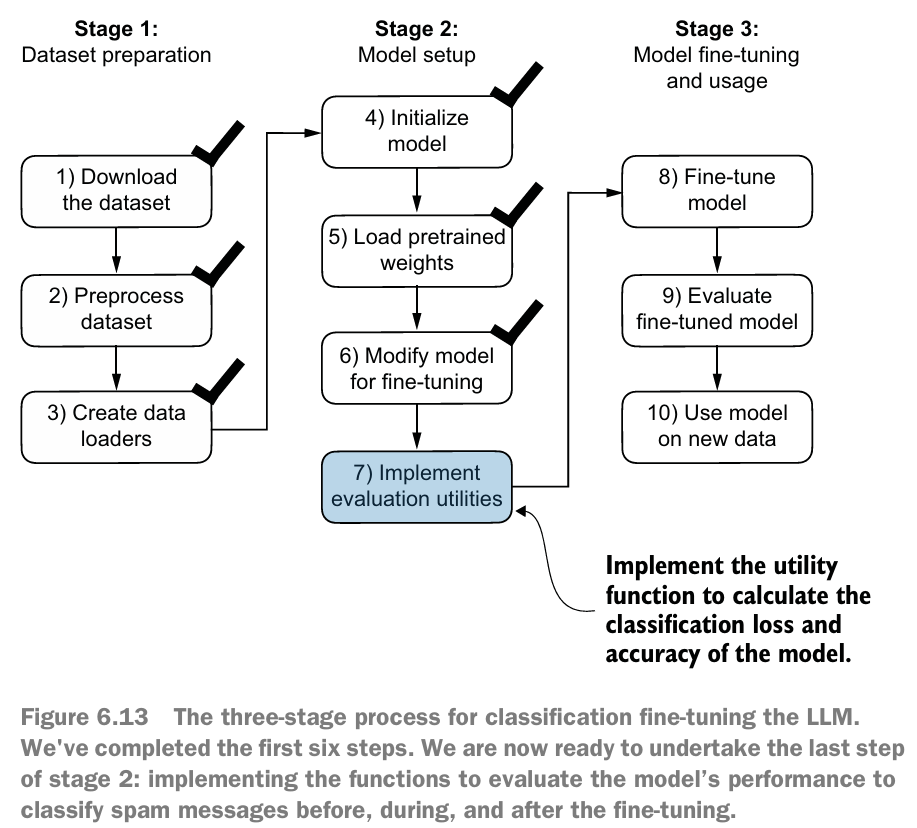






















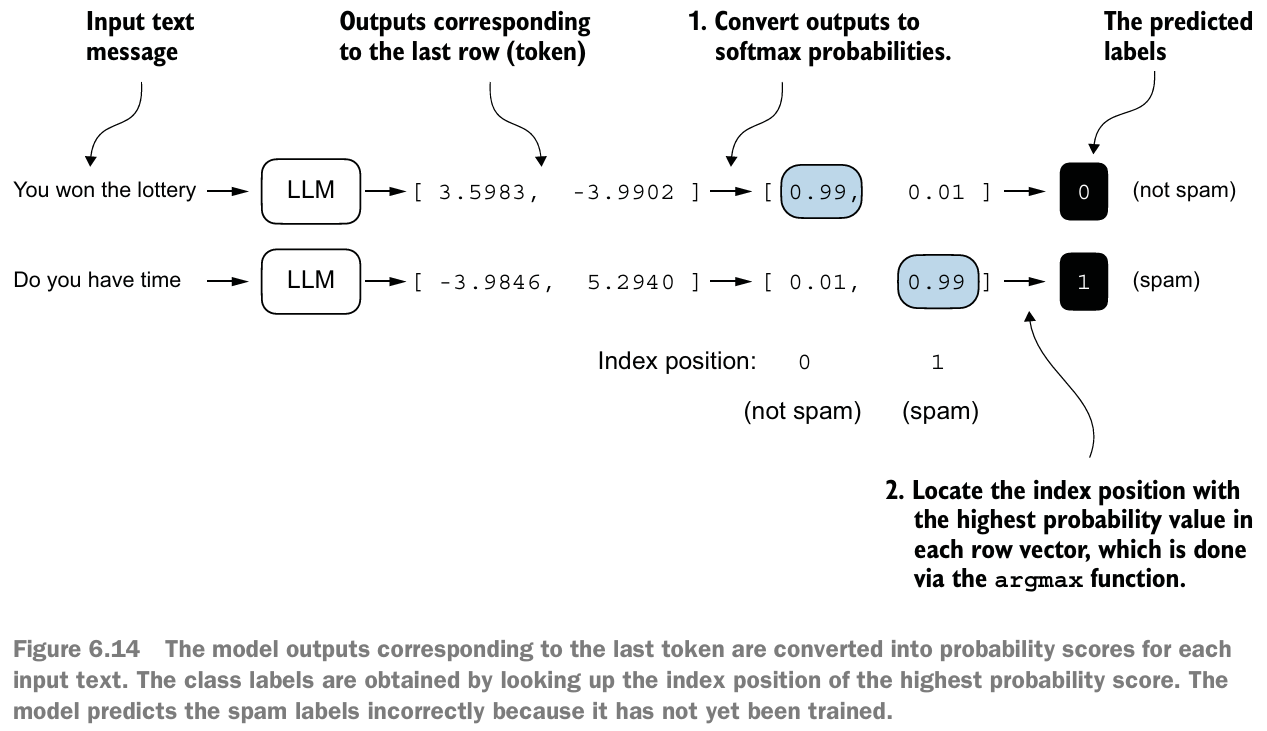

Vamos considerar a última saída do token usando um exemplo concreto:

In [ ]:
print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[-3.5983,  3.9902]])


Os valores do tensor correspondente ao último token são $-3.5983$ e $3.9902$. Podemos obter o rótulo da classe:

In [ ]:
# Aplica a função softmax ao tensor de saída do último token.
# torch.softmax(...): Calcula a função softmax ao longo de uma dimensão específica do tensor.
# outputs[:, -1, :]: Seleciona os scores de saída para o último token de cada sequência no lote, para todas as classes (como explicado no comentário anterior).
# dim=-1: Especifica a dimensão ao longo da qual a função softmax será calculada.
# -1 refere-se à última dimensão, que neste caso é a dimensão das classes (dimensão 2 no tensor outputs[:, -1, :], que tem a forma (tamanho do lote, número de classes)).
# A função softmax converte os scores brutos (logits) em probabilidades que somam 1 ao longo da dimensão especificada.
# O resultado é um tensor 'probas' onde cada valor representa a probabilidade de a entrada pertencer a uma classe específica.
probas = torch.softmax(outputs[:, -1, :], dim=-1)
# Encontra o índice (rótulo da classe) com a maior probabilidade.
# torch.argmax(probas): Retorna o índice do valor máximo no tensor 'probas'.
# Neste caso, como softmax foi aplicado ao longo da dimensão das classes, argmax retornará o índice da classe com a maior probabilidade.
# Para um tensor 'probas' com a forma (tamanho do lote, número de classes), torch.argmax(probas) retornará um tensor com a forma (tamanho do lote,) contendo o índice da classe predita para cada amostra no lote.
label = torch.argmax(probas)
# Imprime o rótulo da classe predito (como um valor Python escalar).
# label.item(): Converte o tensor PyTorch de um único elemento 'label' em um valor Python escalar.
# Isso é útil para imprimir o resultado de forma legível.
# O valor impresso será 0 (não spam) ou 1 (spam), dependendo de qual classe teve a maior probabilidade após a aplicação da softmax.
print("Class label:", label.item())

Class label: 1


Nesse caso, o código retorna 1, o que significa que o modelo prevê que o texto de entrada é "spam". Usar a função `softmax` aqui é opcional, pois as maiores saídas correspondem diretamente às maiores pontuações de probabilidade. Assim, podemos simplificar o código sem usar `softmax`:

In [ ]:
# Extrai os scores de saída (logits) correspondentes ao último token de cada sequência no lote.
# outputs[:, -1, :]: Esta é uma operação de indexação e fatiamento em um tensor PyTorch.
# outputs: Refere-se ao tensor de saída gerado pelo modelo, que tem a forma (tamanho do lote, comprimento da sequência, número de classes).
# : no primeiro índice: Seleciona todas as amostras no lote (todos os lotes).
# -1 no segundo índice: Seleciona o último elemento na dimensão do comprimento da sequência. Em PyTorch e Python, -1 indexa o último item de uma lista ou tensor.
# : no terceiro índice: Seleciona todas as características na dimensão do número de classes (neste caso, ambas as classes, 0 e 1).
# O resultado desta operação é um tensor 'logits' que contém os scores brutos de saída para o último token de cada sequência no lote, para todas as classes.
# Para um lote de tamanho 1 (como no exemplo anterior), o resultado será um tensor com as dimensões (1, 2), onde 1 é o tamanho do lote e 2 são os scores para as classes 'ham' e 'spam'.
logits = outputs[:, -1, :]
# Encontra o índice (rótulo da classe) com o maior score (logit).
# torch.argmax(logits): Retorna o índice do valor máximo no tensor 'logits'.
# Neste caso, como estamos buscando o índice da classe com o score mais alto, argmax retornará o índice da classe predita.
# Para um tensor 'logits' com a forma (tamanho do lote, número de classes), torch.argmax(logits) retornará um tensor com a forma (tamanho do lote,) contendo o índice da classe predita para cada amostra no lote.
# Usar argmax diretamente nos logits é equivalente a usar softmax e depois argmax, pois a função softmax preserva a ordem dos valores (apenas escala e normaliza).
label = torch.argmax(logits)
# Imprime o rótulo da classe predito (como um valor Python escalar).
# label.item(): Converte o tensor PyTorch de um único elemento 'label' em um valor Python escalar.
# Isso é útil para imprimir o resultado de forma legível.
# O valor impresso será 0 (não spam) ou 1 (spam), dependendo de qual classe teve o maior score.
print("Class label:", label.item())

Class label: 1


Este conceito pode ser usado para calcular a precisão de classificação, que mede a porcentagem de previsões corretas em um conjunto de dados.

Para determinar a precisão de classificação, aplicamos o código de previsão baseado em `argmax` a todos os exemplos no conjunto de dados e calculamos a proporção de previsões corretas, definindo uma função `calc_accuracy_loader`.

In [ ]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    # Define a função calc_accuracy_loader que calcula a precisão do modelo em um conjunto de dados carregado por um DataLoader.
    # data_loader: O DataLoader do PyTorch que fornece os dados em lotes.
    # model: A instância do modelo PyTorch a ser avaliada.
    # device: O dispositivo (CPU ou GPU) onde o modelo e os dados estão localizados.
    # num_batches: Um número opcional para limitar a avaliação a um certo número de lotes. Se None, avalia todos os lotes.

    model.eval()
    # Define o modelo para o modo de avaliação (evaluation mode).
    # Isso desativa certas camadas (como dropout) que se comportam de forma diferente durante o treinamento.
    # É crucial para obter resultados de avaliação consistentes e corretos.

    correct_predictions, num_examples = 0, 0
    # Inicializa contadores para o número de previsões corretas e o número total de exemplos avaliados.

    if num_batches is None:
        # Verifica se o número de lotes a serem avaliados foi especificado.
        num_batches = len(data_loader)
        # Se não foi especificado (None), define num_batches para o número total de lotes no DataLoader.
    else:
        # Se num_batches foi especificado, garante que não exceda o número total de lotes disponíveis.
        num_batches = min(num_batches, len(data_loader))
        # Usa min() para pegar o menor valor entre o num_batches especificado e o número real de lotes.

    for i, (input_batch, target_batch) in enumerate(data_loader):
        # Itera sobre os lotes de dados fornecidos pelo data_loader.
        # enumerate(data_loader) retorna o índice (i) e os dados de cada lote (input_batch, target_batch).
        # input_batch: Um tensor contendo as sequências de entrada do lote atual.
        # target_batch: Um tensor contendo os rótulos de classe verdadeiros para as sequências do lote atual.

        if i < num_batches:
            # Verifica se o índice do lote atual é menor que o número de lotes a serem avaliados.
            # Isso permite limitar a avaliação a um subconjunto dos lotes, se num_batches for menor que o total.

            input_batch = input_batch.to(device)
            # Move o tensor de entrada para o dispositivo especificado (CPU ou GPU).
            target_batch = target_batch.to(device)
            # Move o tensor de rótulos alvo para o dispositivo especificado.
            # Isso garante que os dados estejam no mesmo dispositivo que o modelo para computação.

            with torch.no_grad():
                # O bloco 'with torch.no_grad():' desabilita o cálculo de gradientes.
                # Isso é essencial durante a avaliação para economizar memória e tempo,
                # pois não precisamos calcular gradientes para atualizar os pesos.

                logits = model(input_batch)[:, -1, :]
                # Passa o lote de entrada para o modelo para obter as saídas (logits).
                # model(input_batch): Executa o forward pass do modelo com o lote de entrada.
                # [:, -1, :]: Indexa a saída do modelo.
                # : no primeiro índice: Seleciona todas as amostras no lote.
                # -1 no segundo índice: Seleciona o último token de cada sequência no lote.
                # : no terceiro índice: Seleciona todas as características de saída para o último token (os scores para cada classe).
                # O resultado 'logits' é um tensor com a forma (tamanho do lote, número de classes), contendo os scores brutos para cada classe para o último token de cada amostra.

            predicted_labels = torch.argmax(logits, dim=-1)
            # Calcula os rótulos de classe preditos.
            # torch.argmax(logits, dim=-1): Encontra o índice (rótulo da classe) com o maior valor (score) ao longo da última dimensão (dim=-1, a dimensão das classes).
            # Isso retorna um tensor com a forma (tamanho do lote,), onde cada elemento é o rótulo da classe predita para a amostra correspondente.

            num_examples += predicted_labels.shape[0]
            # Adiciona o número de exemplos neste lote ao contador total de exemplos avaliados.
            # predicted_labels.shape[0] retorna o tamanho do lote atual.

            correct_predictions += (
                (predicted_labels == target_batch).sum().item()
            )
            # Compara os rótulos preditos com os rótulos verdadeiros e conta as previsões corretas.
            # (predicted_labels == target_batch): Cria um tensor booleano (True/False) onde True indica uma previsão correta.
            # .sum(): Soma os valores booleanos (True é tratado como 1, False como 0), resultando no número total de previsões corretas neste lote.
            # .item(): Converte o tensor resultante de um único elemento para um valor Python escalar.
            # O número de previsões corretas no lote é adicionado ao contador total correct_predictions.
        else:
            # Se o índice do lote atual for maior ou igual a num_batches, interrompe o loop.
            break

    return correct_predictions / num_examples
    # Calcula a precisão dividindo o número total de previsões corretas pelo número total de exemplos avaliados.
    # Retorna o valor da precisão (um float entre 0 e 1).

Vamos usar a função para determinar as precisões de classificação em vários conjuntos de dados estimados a partir de 10 lotes para eficiência:

In [ ]:
# Define o dispositivo a ser usado para computação (GPU, se disponível, caso contrário, CPU).
# torch.cuda.is_available(): Verifica se uma GPU compatível com CUDA está disponível. Retorna True ou False.
# "cuda" if ... else "cpu": Uma expressão condicional que retorna a string "cuda" se a GPU estiver disponível, caso contrário, retorna a string "cpu".
# torch.device(...): Cria um objeto device que representa o dispositivo selecionado.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Move o modelo para o dispositivo selecionado.
# model.to(device): Move todos os parâmetros e buffers do modelo para o dispositivo especificado.
# Isso garante que o modelo esteja no mesmo dispositivo que os dados durante a computação.
model.to(device)

# Define a semente para o gerador de números aleatórios do PyTorch.
# Isso garante que quaisquer operações aleatórias (como a inicialização de pesos, embora neste caso o modelo já esteja carregado com pesos pré-treinados)
# sejam reproduzíveis.
torch.manual_seed(123)

# Calcula a precisão do modelo no conjunto de dados de treinamento.
# calc_accuracy_loader(...): Chama a função definida anteriormente para calcular a precisão.
# train_loader: O DataLoader para o conjunto de treinamento.
# model: A instância do modelo.
# device: O dispositivo onde o modelo e os dados estão.
# num_batches=10: Limita o cálculo da precisão aos primeiros 10 lotes do conjunto de treinamento para eficiência.
train_accuracy = calc_accuracy_loader(
    train_loader, model, device, num_batches=10
)

# Calcula a precisão do modelo no conjunto de dados de validação.
# Usa o val_loader (DataLoader para o conjunto de validação), o modelo e o dispositivo.
# num_batches=10: Limita o cálculo da precisão aos primeiros 10 lotes do conjunto de validação.
val_accuracy = calc_accuracy_loader(
    val_loader, model, device, num_batches=10
)

# Calcula a precisão do modelo no conjunto de dados de teste.
# Usa o test_loader (DataLoader para o conjunto de teste), o modelo e o dispositivo.
# num_batches=10: Limita o cálculo da precisão aos primeiros 10 lotes do conjunto de teste.
test_accuracy = calc_accuracy_loader(
    test_loader, model, device, num_batches=10
)

# Imprime a precisão calculada para o conjunto de treinamento.
# f"..." : Usa uma f-string para formatar a saída.
# train_accuracy * 100: Converte a precisão (que é um valor entre 0 e 1) em porcentagem.
# :.2f: Formata o número para ter duas casas decimais.
print(f"Training accuracy: {train_accuracy*100:.2f}%")
# Imprime a precisão calculada para o conjunto de validação, formatada como porcentagem com duas casas decimais.
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
# Imprime a precisão calculada para o conjunto de teste, formatada como porcentagem com duas casas decimais.
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 46.25%
Validation accuracy: 45.00%
Test accuracy: 48.75%


Por meio da configuração `device`, o modelo é executado automaticamente em uma GPU se uma GPU com suporte a Nvidia CUDA estiver disponível e, caso contrário, é executado em uma CPU.

Como podemos ver, a precisão das previsões está próxima de uma previsão aleatória, que seria de 50% neste caso. Para melhorar a precisão, precisamos fazer o ajuste fino do modelo.

Antes de iniciarmos o ajuste fino, devemos definir a função de perda que será otimizada durante o treinamento. Nosso objetivo é maximizar a precisão da classificação de spam do modelo, o que significa que o código anterior deve gerar os rótulos de classe corretos: 0 para não spam e 1 para spam.

Como a precisão da classificação não é uma função diferenciável, usamos a perda de entropia cruzada como um substituto para maximizar a precisão. Consequentemente, a função `calc_loss_batch` permanece a mesma, com um ajuste: o foco da otimização é apenas no último token, `model(input_batch)[:, -1, :]`, em vez de em todos os tokens, `model(input_batch)`.

In [ ]:
def calc_loss_batch(input_batch, target_batch, model, device):
    # Define a função calc_loss_batch que calcula a perda (loss) para um lote de dados.
    # Esta função será usada durante o treinamento para otimizar o modelo.
    # input_batch: Um tensor contendo as sequências de entrada do lote atual.
    # target_batch: Um tensor contendo os rótulos de classe verdadeiros para as sequências do lote atual.
    # model: A instância do modelo PyTorch.
    # device: O dispositivo (CPU ou GPU) onde o modelo e os dados estão localizados.

    input_batch = input_batch.to(device)
    # Move o tensor de entrada para o dispositivo especificado (CPU ou GPU).
    # Isso garante que os dados estejam no mesmo dispositivo que o modelo para a computação.
    target_batch = target_batch.to(device)
    # Move o tensor de rótulos alvo para o dispositivo especificado.
    # Isso garante que os rótulos estejam no mesmo dispositivo que os dados para o cálculo da perda.

    logits = model(input_batch)[:, -1, :]
    # Passa o lote de entrada para o modelo para obter as saídas (logits).
    # model(input_batch): Executa o forward pass do modelo com o lote de entrada.
    # [:, -1, :]: Indexa a saída do modelo para focar apenas no último token de cada sequência no lote.
    # : no primeiro índice: Seleciona todas as amostras no lote.
    # -1 no segundo índice: Seleciona o último elemento na dimensão do comprimento da sequência.
    # : no terceiro índice: Seleciona todas as características de saída para o último token (os scores para cada classe).
    # O resultado 'logits' é um tensor com a forma (tamanho do lote, número de classes), contendo os scores brutos para cada classe para o último token de cada amostra.

    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    # Calcula a perda de entropia cruzada entre os logits preditos e os rótulos alvo verdadeiros.
    # torch.nn.functional.cross_entropy: Esta é uma função de perda comum para problemas de classificação multiclasse (ou binária, como neste caso).
    # Ela combina a função Softmax (para converter logits em probabilidades) e a NLLLoss (Negative Log Likelihood Loss) em uma única função eficiente.
    # logits: O tensor de scores brutos de saída do modelo (forma: tamanho do lote, número de classes).
    # target_batch: O tensor contendo os rótulos de classe verdadeiros (forma: tamanho do lote, contendo os índices das classes).
    # A função calcula a perda comparando as probabilidades preditas (derivadas dos logits) com a distribuição de probabilidade real (one-hot encoding dos rótulos alvo).
    # O objetivo do treinamento é minimizar esta perda.

    return loss
    # Retorna o valor da perda calculada para o lote atual.

Usamos a função `calc_loss_batch` para calcular a perda para um único lote obtido dos carregadores de dados definidos anteriormente. Para calcular a perda para todos os lotes em um carregador de dados, definimos a função `calc_loss_loader` como antes.

In [ ]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    # Define a função calc_loss_loader que calcula a perda média em um conjunto de dados inteiro ou em um subconjunto de lotes.
    # data_loader: O DataLoader do PyTorch que fornece os dados em lotes.
    # model: A instância do modelo PyTorch a ser avaliada.
    # device: O dispositivo (CPU ou GPU) onde o modelo e os dados estão localizados.
    # num_batches: Um número opcional para limitar o cálculo da perda a um certo número de lotes. Se None, calcula a perda em todos os lotes.

    total_loss = 0.
    # Inicializa uma variável para acumular a perda total ao longo dos lotes.

    if len(data_loader) == 0:
        # Verifica se o DataLoader está vazio (não contém nenhum lote).
        return float("nan")
        # Se estiver vazio, retorna "NaN" (Not a Number) para indicar que a perda não pode ser calculada.

    elif num_batches is None:
        # Verifica se o número de lotes a serem avaliados foi especificado.
        # Se não foi especificado (None), define num_batches para o número total de lotes no DataLoader.
        num_batches = len(data_loader)
    else:
        # Se num_batches foi especificado, garante que não exceda o número total de lotes disponíveis.
        # Usa min() para pegar o menor valor entre o num_batches especificado e o número real de lotes.
        num_batches = min(num_batches, len(data_loader)) # Garante que o número de lotes não exceda os lotes no carregador de dados

    for i, (input_batch, target_batch) in enumerate(data_loader):
        # Itera sobre os lotes de dados fornecidos pelo data_loader.
        # enumerate(data_loader) retorna o índice (i) e os dados de cada lote (input_batch, target_batch).
        # input_batch: Um tensor contendo as sequências de entrada do lote atual.
        # target_batch: Um tensor contendo os rótulos de classe verdadeiros para as sequências do lote atual.

        if i < num_batches:
            # Verifica se o índice do lote atual é menor que o número de lotes a serem avaliados.
            # Isso permite limitar o cálculo da perda a um subconjunto dos lotes, se num_batches for menor que o total.

            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            # Chama a função calc_loss_batch (definida anteriormente) para calcular a perda para o lote atual.
            # Passa o lote de entrada, o lote de rótulos alvo, o modelo e o dispositivo.
            # A função retorna a perda calculada para o lote.

            total_loss += loss.item()
            # Adiciona o valor escalar da perda do lote atual (loss.item()) à perda total acumulada.
            # .item() é usado para extrair o valor Python escalar de um tensor PyTorch contendo um único elemento.
        else:
            # Se o índice do lote atual for maior ou igual a num_batches, interrompe o loop.
            break

    return total_loss / num_batches
    # Calcula a perda média dividindo a perda total acumulada pelo número de lotes processados.
    # Retorna o valor da perda média (um float). Esta métrica indica o quão bem o modelo está se saindo
    # em prever os rótulos corretos para os dados. Um valor de perda menor geralmente indica um desempenho melhor.

Semelhante ao cálculo da precisão do treinamento, agora calculamos a perda inicial para cada conjunto de dados:

In [ ]:
with torch.no_grad(): # Desabilita o rastreamento de gradiente para maior eficiência, já que ainda não estamos treinando
    # Calcula a perda para o conjunto de treinamento usando a função calc_loss_loader.
    # train_loader: DataLoader para o conjunto de treinamento.
    # model: O modelo a ser avaliado.
    # device: O dispositivo onde os cálculos serão realizados.
    # num_batches=5: Limita o cálculo a apenas 5 lotes para uma estimativa rápida.
    train_loss = calc_loss_loader(
        train_loader, model, device, num_batches=5
    )

    # Calcula a perda para o conjunto de validação.
    # val_loader: DataLoader para o conjunto de validação.
    # num_batches=5: Limita o cálculo a apenas 5 lotes.
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    # Calcula a perda para o conjunto de teste.
    # test_loader: DataLoader para o conjunto de teste.
    # num_batches=5: Limita o cálculo a apenas 5 lotes.
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)

# Imprime a perda calculada para o conjunto de treinamento.
# f"..." : Usa uma f-string para formatar a saída.
# train_loss:.3f: Formata o valor da perda de treinamento para ter 3 casas decimais.
print(f"Training loss: {train_loss:.3f}")
# Imprime a perda calculada para o conjunto de validação, formatada para 3 casas decimais.
print(f"Validation loss: {val_loss:.3f}")
# Imprime a perda calculada para o conjunto de teste, formatada para 3 casas decimais.
print(f"Test loss: {test_loss:.3f}")

Training loss: 2.453
Validation loss: 2.583
Test loss: 2.322


Em seguida, implementaremos uma função de treinamento para ajustar o modelo, o que significa ajustá-lo para minimizar a perda do conjunto de treinamento. Minimizar a perda do conjunto de treinamento ajudará a aumentar a precisão da classificação, que é nosso objetivo geral.

## **7 Ajuste fino do modelo em dados supervisionados**

Precisamos definir e usar a função de treinamento para fazer o ajuste fino do LLM pré-treinado e melhorar sua precisão na classificação de spam. O loop de treinamento, ilustrado na figura 6.15, é o mesmo loop de treinamento geral que usamos para o pré-treinamento; a única diferença é que calculamos a precisão da classificação em vez de gerar um texto de exemplo para avaliar o modelo.

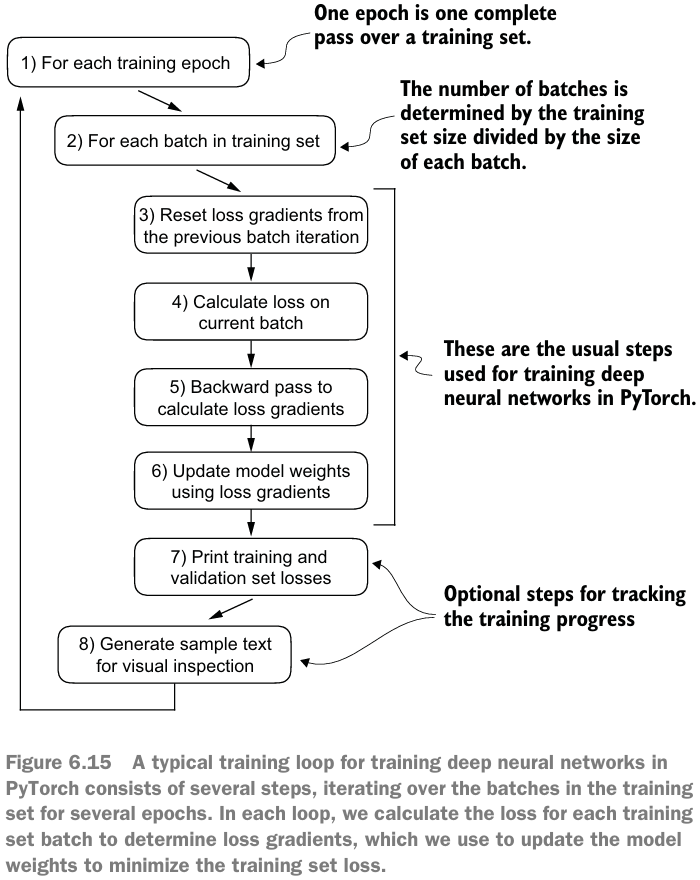

A função de treinamento que implementa os conceitos mostrados na figura 6.15 também é muito semelhante à função `train_model_simple` usada no pré-treinamento do modelo. As únicas duas diferenças são que agora rastreamos o número de exemplos de treinamento vistos (`examples_seen`) em vez do número de tokens, e calculamos a precisão após cada época em vez de imprimir um texto de exemplo.

In [ ]:
def train_classifier_simple(
        model, train_loader, val_loader, optimizer, device,
        num_epochs, eval_freq, eval_iter):
    """
    Função principal para treinar um classificador

    Parâmetros:
    - model: modelo de rede neural a ser treinado
    - train_loader: DataLoader com dados de treinamento
    - val_loader: DataLoader com dados de validação
    - optimizer: otimizador para atualizar os pesos do modelo
    - device: dispositivo onde o modelo será executado (CPU/GPU)
    - num_epochs: número total de épocas de treinamento
    - eval_freq: frequência de avaliação (a cada quantos steps)
    - eval_iter: número de batches usados na avaliação
    """

    # Inicializa listas para rastrear perdas e exemplos vistos
    # train_losses: armazena as perdas no conjunto de treino durante o treinamento
    # val_losses: armazena as perdas no conjunto de validação durante o treinamento
    # train_accs: armazena as acurácias no conjunto de treino
    # val_accs: armazena as acurácias no conjunto de validação
    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    # examples_seen: contador do número total de exemplos processados
    # global_step: contador do número total de passos de treinamento (inicia em -1)
    examples_seen, global_step = 0, -1

    # Loop principal de treinamento - cada época representa uma passagem completa pelo dataset
    for epoch in range(num_epochs):
        model.train() # Define o modelo para o modo de treinamento
        # Isso ativa camadas como Dropout e BatchNorm que se comportam diferente
        # durante treinamento vs inferência

        # Itera sobre todos os batches do dataset de treinamento
        # train_loader fornece batches de (dados_entrada, rotulos)
        for input_batch, target_batch in train_loader:
            # Zera os gradientes acumulados do otimizador
            # IMPORTANTE: sem isso, os gradientes seriam acumulados entre batches
            optimizer.zero_grad()

            # Calcula a perda para o batch atual
            # input_batch: tensor com dados de entrada
            # target_batch: tensor com rótulos verdadeiros
            # model: modelo que faz a predição
            # device: garante que dados e modelo estão no mesmo dispositivo
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )

            # Backpropagation: calcula gradientes da perda em relação aos parâmetros
            # Propaga o erro de volta através da rede para calcular derivadas
            loss.backward()

            # Atualiza os pesos do modelo usando os gradientes calculados
            # O otimizador aplica a regra de atualização (ex: SGD, Adam)
            optimizer.step()

            # Atualiza contadores
            examples_seen += input_batch.shape[0]  # Adiciona tamanho do batch ao contador
            global_step += 1  # Incrementa contador de passos

            # Passo de avaliação opcional - verifica se é hora de avaliar o modelo
            # eval_freq determina a cada quantos steps fazemos avaliação
            if global_step % eval_freq == 0:
                # Avalia o modelo nos conjuntos de treino e validação
                # Retorna as perdas médias em ambos os conjuntos
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )

                # Armazena as perdas para análise posterior
                train_losses.append(train_loss)
                val_losses.append(val_loss)

                # Exibe progresso do treinamento
                print(f"Ep {epoch+1} | Step {global_step:06d}: "
                      f"Train loss {train_loss:.3f} | "
                      f"Val loss {val_loss:.3f}")

        # Calcula a precisão após cada época completa
        # Avalia quantas predições o modelo acerta no conjunto de treino
        train_accuracy = calc_accuracy_loader(
            train_loader, model, device, num_batches=eval_iter
        )

        # Avalia quantas predições o modelo acerta no conjunto de validação
        val_accuracy = calc_accuracy_loader(
            val_loader, model, device, num_batches=eval_iter
        )

        # Exibe as acurácias de treino e validação
        # end="" evita quebra de linha entre os dois prints
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")

        # Armazena as acurácias para análise posterior
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    # Retorna todas as métricas coletadas durante o treinamento
    # Esses dados permitem analisar a evolução do modelo e criar gráficos
    return train_losses, val_losses, train_accs, val_accs, examples_seen

A função `evaluate_model` é idêntica à que usamos para o pré-treinamento:

In [ ]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    # Define a função evaluate_model que avalia o modelo nos conjuntos de treinamento e validação.
    # model: A instância do modelo PyTorch a ser avaliada.
    # train_loader: DataLoader para o conjunto de treinamento.
    # val_loader: DataLoader para o conjunto de validação.
    # device: O dispositivo (CPU ou GPU) onde o modelo e os dados estão localizados.
    # eval_iter: O número de lotes a serem usados para avaliação em cada DataLoader.

    model.eval()
    # Define o modelo para o modo de avaliação (evaluation mode).
    # Isso desativa certas camadas (como dropout) que se comportam de forma diferente durante o treinamento.
    # É crucial para obter resultados de avaliação consistentes e corretos.

    with torch.no_grad():
        # O bloco 'with torch.no_grad():' desabilita o cálculo de gradientes.
        # Isso é essencial durante a avaliação para economizar memória e tempo,
        # pois não precisamos calcular gradientes para atualizar os pesos.

        train_loss = calc_loss_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        # Calcula a perda no conjunto de treinamento usando a função calc_loss_loader.
        # Passa o DataLoader de treinamento, o modelo, o dispositivo e o número de lotes para avaliação.
        # O resultado é a perda média no conjunto de treinamento.

        val_loss = calc_loss_loader(
            val_loader, model, device, num_batches=eval_iter
        )
        # Calcula a perda no conjunto de validação usando a função calc_loss_loader.
        # Passa o DataLoader de validação, o modelo, o dispositivo e o número de lotes para avaliação.
        # O resultado é a perda média no conjunto de validação.

    model.train()
    # Define o modelo de volta para o modo de treinamento (training mode).
    # Isso reativa camadas como Dropout e BatchNorm para que se comportem corretamente
    # quando o treinamento for retomado após a avaliação.

    return train_loss, val_loss
    # Retorna a perda calculada para os conjuntos de treinamento e validação como uma tupla.
    # Essas perdas são usadas para monitorar o progresso do treinamento e detectar overfitting.

Em seguida, inicializamos o otimizador, definimos o número de épocas de treinamento e iniciamos o treinamento usando a função `train_classifier_simple`. O treinamento leva cerca de 6 minutos em um laptop MacBook Air M3 e menos de meio minuto em uma GPU V100 ou A100.

In [ ]:
import time # Importa o módulo time para medir o tempo de execução do treinamento.

start_time = time.time() # Registra o tempo de início do treinamento.
torch.manual_seed(123) # Define a semente para o gerador de números aleatórios do PyTorch para garantir a reprodutibilidade dos resultados.
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1) # Inicializa o otimizador AdamW.
# torch.optim.AdamW: Otimizador popular para redes neurais que implementa o algoritmo Adam com correção de peso.
# model.parameters(): Passa todos os parâmetros treináveis do modelo para o otimizador. O otimizador saberá quais parâmetros precisam ser atualizados.
# lr=5e-5: Define a taxa de aprendizado (learning rate). Um valor menor (5e-5 = 0.00005) indica passos menores durante a otimização, o que pode ajudar a convergir para um bom mínimo.
# weight_decay=0.1: Adiciona regularização L2 (decaimento de peso) aos parâmetros. Isso ajuda a prevenir o overfitting penalizando pesos grandes.

num_epochs = 5 # Define o número total de épocas de treinamento. Uma época é uma passagem completa por todo o conjunto de dados de treinamento.

# Chama a função train_classifier_simple para iniciar o processo de treinamento.
# Esta função executa o loop de treinamento, calcula perdas e acurácias e retorna as métricas coletadas.
train_losses, val_losses, train_accs, val_accs, examples_seen = \
train_classifier_simple(
    model, # model: A instância do modelo a ser treinado.
    train_loader, # train_loader: DataLoader que fornece os dados de treinamento em lotes.
    val_loader, # val_loader: DataLoader que fornece os dados de validação em lotes (usado para avaliação periódica).
    optimizer, # optimizer: O otimizador configurado para atualizar os pesos do modelo.
    device, # device: O dispositivo (CPU/GPU) onde o treinamento ocorrerá.
    num_epochs=num_epochs, # num_epochs: O número total de épocas para treinar (usando a variável definida acima).
    eval_freq=50, # eval_freq: A frequência com que a avaliação nos conjuntos de treinamento e validação será realizada (a cada 50 passos/batches de treinamento).
    eval_iter=5 # eval_iter: O número de lotes a serem usados dos DataLoaders de treinamento e validação durante cada avaliação.
)

end_time = time.time() # Registra o tempo de término do treinamento.
execution_time_minutes = (end_time - start_time) / 60 # Calcula a duração total do treinamento em minutos.
print(f"Training completed in {execution_time_minutes:.2f} minutes.") # Imprime o tempo de execução formatado para duas casas decimais.

Ep 1 | Step 000000: Train loss 1.798 | Val loss 1.997
Ep 1 | Step 000050: Train loss 0.614 | Val loss 0.636
Ep 1 | Step 000100: Train loss 0.517 | Val loss 0.551
Training accuracy: 70.00% | Validation accuracy: 72.50%
Ep 2 | Step 000150: Train loss 0.567 | Val loss 0.487
Ep 2 | Step 000200: Train loss 0.418 | Val loss 0.393
Ep 2 | Step 000250: Train loss 0.406 | Val loss 0.350
Training accuracy: 82.50% | Validation accuracy: 85.00%
Ep 3 | Step 000300: Train loss 0.274 | Val loss 0.245
Ep 3 | Step 000350: Train loss 0.246 | Val loss 0.125
Training accuracy: 95.00% | Validation accuracy: 95.00%
Ep 4 | Step 000400: Train loss 0.054 | Val loss 0.106
Ep 4 | Step 000450: Train loss 0.108 | Val loss 0.081
Ep 4 | Step 000500: Train loss 0.189 | Val loss 0.084
Training accuracy: 97.50% | Validation accuracy: 97.50%
Ep 5 | Step 000550: Train loss 0.197 | Val loss 0.096
Ep 5 | Step 000600: Train loss 0.060 | Val loss 0.050
Training accuracy: 100.00% | Validation accuracy: 97.50%
Training complete

Em seguida, usamos o Matplotlib para plotar a função de perda para o conjunto de treinamento e validação.

In [ ]:
import matplotlib.pyplot as plt # Importa a biblioteca matplotlib.pyplot, comumente usada para criar visualizações (gráficos).

def plot_values(
        epochs_seen, examples_seen, train_values, val_values,
        label="loss"):
    """
    Função para plotar valores (como perda ou acurácia) ao longo das épocas e exemplos vistos.

    Parâmetros:
    - epochs_seen: Tensor ou lista de valores representando as épocas em que as métricas foram registradas.
    - examples_seen: Tensor ou lista de valores representando o número total de exemplos vistos nas épocas correspondentes.
    - train_values: Lista de valores da métrica (perda ou acurácia) no conjunto de treinamento.
    - val_values: Lista de valores da métrica (perda ou acurácia) no conjunto de validação.
    - label: String que descreve a métrica que está sendo plotada (ex: "loss", "accuracy"). Usado para rótulos do gráfico e nome do arquivo.
    """

    # Cria uma figura e um conjunto de eixos para o plot.
    # fig: O objeto Figure, que contém todos os elementos do plot.
    # ax1: O objeto Axes, que representa o sistema de coordenadas onde os dados são plotados.
    # figsize=(5, 3): Define o tamanho da figura em polegadas (largura, altura).
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plota a métrica (loss ou accuracy) do conjunto de treinamento no eixo ax1.
    # epochs_seen: Valores no eixo X (épocas).
    # train_values: Valores no eixo Y (métrica de treinamento).
    # label=f"Training {label}": Rótulo para a linha no gráfico (ex: "Training loss" ou "Training accuracy").
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    # Plota a métrica (loss ou accuracy) do conjunto de validação no eixo ax1.
    # epochs_seen: Valores no eixo X (épocas).
    # val_values: Valores no eixo Y (métrica de validação).
    # linestyle="-." : Define o estilo da linha (traço-ponto) para diferenciar do treinamento.
    # label=f"Validation {label}": Rótulo para a linha no gráfico (ex: "Validation loss" ou "Validation accuracy").
    ax1.plot(
        epochs_seen, val_values, linestyle="-.",
        label=f"Validation {label}"
    )

    # Define o rótulo do eixo X principal.
    ax1.set_xlabel("Epochs")
    # Define o rótulo do eixo Y principal. Capitaliza a primeira letra do 'label' (ex: "Loss" ou "Accuracy").
    ax1.set_ylabel(label.capitalize())
    # Adiciona a legenda ao gráfico, usando os rótulos definidos nas chamadas plot().
    ax1.legend()

    # Cria um segundo eixo X que compartilha o eixo Y com ax1.
    # Isso permite ter um eixo X na parte superior do gráfico que representa uma escala diferente (exemplos vistos).
    ax2 = ax1.twiny()
    # Plota um gráfico "invisível" no segundo eixo X.
    # examples_seen: Valores no eixo X (exemplos vistos).
    # train_values: Valores no eixo Y (os mesmos valores da métrica de treinamento).
    # alpha=0: Torna a linha completamente transparente. O objetivo é apenas usar esses dados para alinhar os tiques do segundo eixo X.
    ax2.plot(examples_seen, train_values, alpha=0) # Plot invisível para alinhar os tiques
    # Define o rótulo do segundo eixo X.
    ax2.set_xlabel("Examples seen")

    # Ajusta automaticamente os parâmetros do subplot para que eles se encaixem na área da figura.
    # Isso evita que rótulos ou títulos se sobreponham.
    fig.tight_layout() # Ajusta o layout para abrir espaço
    # Salva a figura plotada em um arquivo PDF.
    # f"{label}-plot.pdf": Define o nome do arquivo com base no 'label' (ex: "loss-plot.pdf" ou "accuracy-plot.pdf").
    plt.savefig(f"{label}-plot.pdf")
    # Exibe o gráfico na tela.
    plt.show()

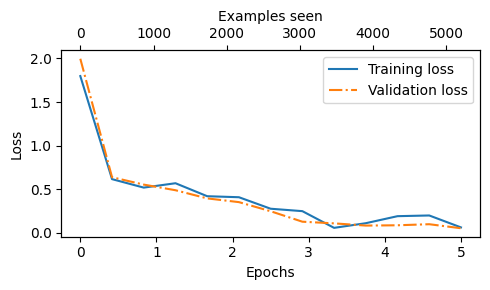

In [ ]:
# Cria um tensor PyTorch com valores uniformemente espaçados de 0 ao número total de épocas.
# torch.linspace(start, end, steps): Retorna um tensor 1D contendo 'steps' pontos igualmente espaçados entre 'start' e 'end' (inclusive).
# 0: O valor inicial (primeira época).
# num_epochs: O valor final (última época).
# len(train_losses): O número de pontos a serem gerados, que corresponde ao número de vezes que a perda de treinamento foi registrada (uma vez por época).
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
# Cria um tensor PyTorch com valores uniformemente espaçados de 0 ao número total de exemplos vistos.
# 0: O valor inicial (antes de ver qualquer exemplo).
# examples_seen: O valor final (o número total de exemplos vistos ao final do treinamento).
# len(train_losses): O número de pontos, para corresponder ao número de pontos no eixo das épocas.
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

# Chama a função plot_values para gerar o gráfico da perda.
# epochs_tensor: Passa os valores das épocas para o eixo X principal.
# examples_seen_tensor: Passa os valores dos exemplos vistos para o segundo eixo X.
# train_losses: Passa a lista de perdas de treinamento.
# val_losses: Passa a lista de perdas de validação.
# O parâmetro 'label' usa o valor padrão "loss".
plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

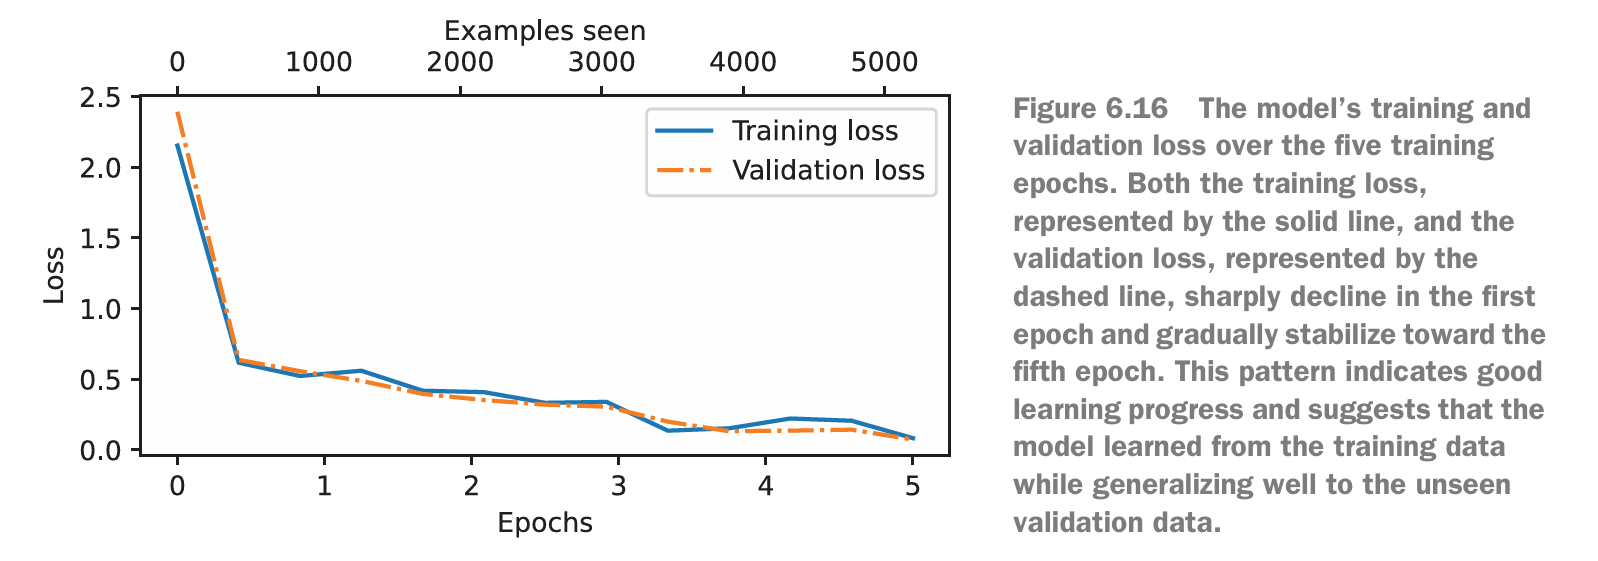

Com base na inclinação descendente acentuada na figura 6.16, o modelo está aprendendo bem a partir dos dados de treinamento, e há pouca ou nenhuma indicação de sobreajuste (overfitting); ou seja, não há uma lacuna perceptível entre as perdas dos conjuntos de treinamento e validação.

---

$\large \textbf{Escolhendo o número de épocas}$

Anteriormente, ao iniciar o treinamento, o número de épocas foi definido como cinco. O número de épocas depende do conjunto de dados e da dificuldade da tarefa, e não há uma solução universal ou recomendação, embora cinco épocas seja geralmente um bom ponto de partida. Se o modelo apresentar sobreajuste após as primeiras épocas, como um gráfico de perda, talvez seja necessário reduzir o número de épocas. Por outro lado, se a linha de tendência sugerir que a perda de validação poderia melhorar com mais treinamento, o número de épocas deve ser aumentado. Neste caso específico, cinco épocas é um número razoável, pois não há sinais de sobreajuste precoce, e a perda de validação está próxima de 0.

---

Usando a mesma função `plot_values`, vamos agora plotar as precisões de classificação:

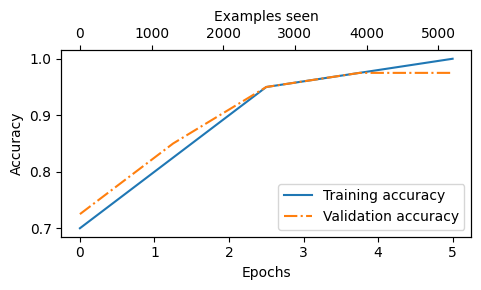

In [ ]:
# Cria um tensor PyTorch com valores uniformemente espaçados de 0 ao número total de épocas.
# torch.linspace(start, end, steps): Retorna um tensor 1D contendo 'steps' pontos igualmente espaçados entre 'start' e 'end' (inclusive).
# 0: O valor inicial (primeira época).
# num_epochs: O valor final (última época).
# len(train_accs): O número de pontos a serem gerados, que corresponde ao número de vezes que a acurácia de treinamento foi registrada (uma vez por época).
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
# Cria um tensor PyTorch com valores uniformemente espaçados de 0 ao número total de exemplos vistos.
# 0: O valor inicial (antes de ver qualquer exemplo).
# examples_seen: O valor final (o número total de exemplos vistos ao final do treinamento).
# len(train_accs): O número de pontos, para corresponder ao número de pontos no eixo das épocas.
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

# Chama a função plot_values para gerar o gráfico da acurácia.
# epochs_tensor: Passa os valores das épocas para o eixo X principal.
# examples_seen_tensor: Passa os valores dos exemplos vistos para o segundo eixo X.
# train_accs: Passa a lista de acurácias de treinamento.
# val_accs: Passa a lista de acurácias de validação.
# label="accuracy": Define o rótulo para o gráfico como "accuracy".
plot_values(
    epochs_tensor, examples_seen_tensor, train_accs, val_accs,
    label="accuracy"
)

A figura 6.17 mostra o gráfico da precisão resultante. O modelo alcança uma precisão de treinamento e validação relativamente alta após as épocas 4 e 5. É importante notar que, anteriormente, definimos `eval_iter=5` ao usar a função `train_classifier_simple`, o que significa que as estimativas de desempenho de treinamento e validação foram baseadas em apenas cinco lotes, visando a eficiência durante o treinamento.

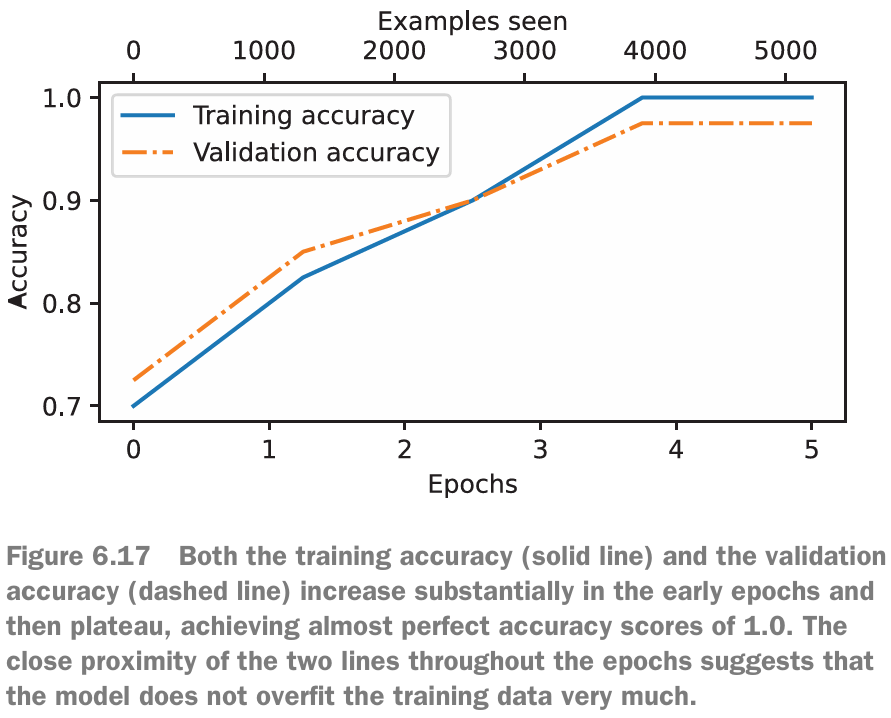

Agora, é necessário calcular as métricas de desempenho para os conjuntos de treinamento, validação e teste em todo o conjunto de dados, executando o código a seguir, mas desta vez sem definir o valor de `eval_iter`.

In [ ]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
# Chama a função calc_accuracy_loader para calcular a precisão no conjunto de treinamento completo.
# train_loader: O DataLoader para o conjunto de treinamento.
# model: A instância do modelo a ser avaliada.
# device: O dispositivo onde os cálculos serão realizados.
# Como o parâmetro num_batches não é especificado, a função calculará a precisão em todos os lotes do train_loader.

val_accuracy = calc_accuracy_loader(val_loader, model, device)
# Chama a função calc_accuracy_loader para calcular a precisão no conjunto de validação completo.
# val_loader: O DataLoader para o conjunto de validação.
# model: A instância do modelo a ser avaliada.
# device: O dispositivo onde os cálculos serão realizados.
# Como o parâmetro num_batches não é especificado, a função calculará a precisão em todos os lotes do val_loader.

test_accuracy = calc_accuracy_loader(test_loader, model, device)
# Chama a função calc_accuracy_loader para calcular a precisão no conjunto de teste completo.
# test_loader: O DataLoader para o conjunto de teste.
# model: A instância do modelo a ser avaliada.
# device: O dispositivo onde os cálculos serão realizados.
# Como o parâmetro num_batches não é especificado, a função calculará a precisão em todos os lotes do test_loader.

print(f"Training accuracy: {train_accuracy*100:.2f}%")
# Imprime a precisão calculada para o conjunto de treinamento.
# train_accuracy * 100: Converte a precisão (que é um valor entre 0 e 1) em porcentagem.
# :.2f: Formata o número para ter duas casas decimais.
# f"..." : Usa uma f-string para formatar a string de saída.

print(f"Validation accuracy: {val_accuracy*100:.2f}%")
# Imprime a precisão calculada para o conjunto de validação, formatada como porcentagem com duas casas decimais.

print(f"Test accuracy: {test_accuracy*100:.2f}%")
# Imprime a precisão calculada para o conjunto de teste, formatada como porcentagem com duas casas decimais.

Training accuracy: 97.60%
Validation accuracy: 97.99%
Test accuracy: 96.33%


O desempenho dos conjuntos de treinamento e teste é quase idêntico. A pequena discrepância entre as precisões de treinamento e teste sugere um **sobreajuste mínimo** dos dados de treinamento. Normalmente, a precisão do conjunto de validação é um pouco maior do que a precisão do conjunto de teste, porque o desenvolvimento do modelo frequentemente envolve o ajuste de hiperparâmetros para um bom desempenho no conjunto de validação, o que pode não se generalizar de forma tão eficaz para o conjunto de teste. Essa situação é comum, mas a diferença pode ser minimizada ajustando as configurações do modelo, como aumentando a taxa de **dropout** (`drop_rate`) ou o parâmetro `weight_decay` na configuração do otimizador.

## **8 - Usando o LLM como um classificador de spam**

Após o ajuste fino e a avaliação do modelo, agora ele está pronto para classificar mensagens de spam. Vamos usar o modelo de classificação de spam ajustado, que é baseado em GPT. A função `classify_review` a seguir segue etapas de pré-processamento de dados semelhantes às que foram usadas na implementação anterior do `SpamDataset`. Depois de processar o texto e transformá-lo em IDs de token, a função usa o modelo para prever um rótulo de classe inteiro, de forma parecida com o que foi implementado na seção 6.6, e então retorna o nome da classe correspondente.

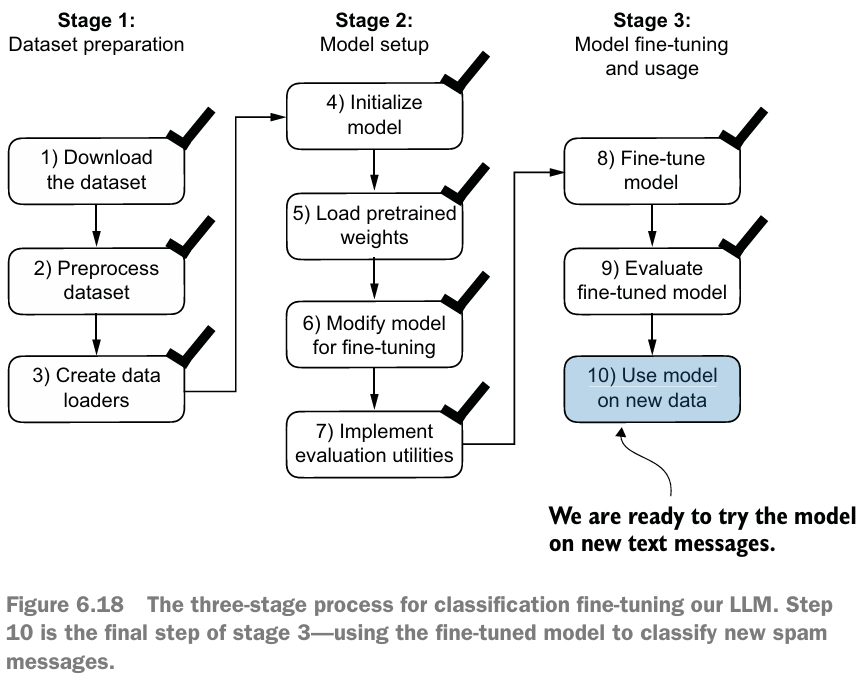

In [ ]:
def classify_review(
        text, model, tokenizer, device, max_length=None,
        pad_token_id=50256):
    # Define a função classify_review que classifica um texto de entrada como "spam" ou "not spam" usando o modelo treinado.
    # text: A string de texto de entrada a ser classificada.
    # model: A instância do modelo PyTorch treinado para classificação de spam.
    # tokenizer: O tokenizador (tiktoken) usado para converter texto em IDs de token.
    # device: O dispositivo (CPU ou GPU) onde o modelo e os dados estão localizados.
    # max_length: O comprimento máximo para o qual as sequências serão preenchidas ou truncadas. Se None, a função tentará usar o comprimento de contexto suportado pelo modelo.
    # pad_token_id: O ID do token usado para preenchimento (padding). O padrão é 50256, que é o ID para '<|endoftext|>' no tokenizador GPT-2.

    model.eval() # Prepara o modelo para inferência (evaluation mode).
    # Isso desativa camadas como Dropout e BatchNorm, garantindo resultados determinísticos e eficientes para a classificação.

    input_ids = tokenizer.encode(text)
    # Tokeniza a string de texto de entrada ('text') em uma lista de IDs de token numéricos usando o tokenizador fornecido.

    supported_context_length = model.pos_emb.weight.shape[1]
    # Obtém o comprimento máximo de contexto suportado pelo modelo.
    # model.pos_emb.weight.shape[1] acessa a segunda dimensão dos pesos do embedding de posição do modelo, que corresponde ao comprimento máximo da sequência que o modelo pode processar.

    # Trunca as sequências se forem muito longas
    # Compara o comprimento da sequência codificada com o comprimento máximo especificado (se houver) e o comprimento de contexto suportado pelo modelo.
    # min(max_length, supported_context_length): Retorna o menor valor entre max_length (se não for None) e supported_context_length. Se max_length for None, esta parte será apenas supported_context_length.
    # input_ids[:min(...)]: Seleciona os IDs de token do início da lista 'input_ids' até o índice determinado pelo valor mínimo. Isso efetivamente trunca a sequência se ela for mais longa que o comprimento máximo permitido.
    input_ids = input_ids[:min(
        max_length, supported_context_length # Garante que não exceda o comprimento de contexto do modelo
    )]


    # Preenche as sequências para o comprimento da sequência mais longa (definida por max_length, que foi truncado se necessário)
    # Calcula quantos tokens de padding são necessários: a diferença entre o comprimento máximo desejado (após truncamento) e o comprimento atual da sequência.
    # [pad_token_id] * (...): Cria uma lista contendo o 'pad_token_id' repetido o número de vezes necessário para o preenchimento.
    # input_ids + [...]: Concatena a lista original de IDs de token (após truncamento) com a lista de IDs de padding. Isso adiciona tokens de padding ao final da sequência.
    input_ids += [pad_token_id] * (max_length - len(input_ids))


    # Adiciona a dimensão do lote
    # Converte a lista final de IDs de token (truncada e preenchida) em um tensor PyTorch.
    # torch.tensor(input_ids, device=device): Cria um tensor a partir da lista 'input_ids' e o move para o dispositivo especificado.
    # .unsqueeze(0): Adiciona uma nova dimensão na posição 0. Isso transforma o tensor de forma (comprimento da sequência) para (1, comprimento da sequência), simulando um lote de tamanho 1, que é o formato esperado pelo modelo.
    input_tensor = torch.tensor(
        input_ids, device=device
    ).unsqueeze(0)

    # Inferência do modelo sem rastreamento de gradiente
    # O bloco 'with torch.no_grad():' desabilita o cálculo de gradientes durante a execução do código dentro dele.
    # Isso é crucial para a inferência, pois não precisamos de gradientes para atualizar os pesos, economizando memória e acelerando a computação.
    with torch.no_grad():
        # Passa o tensor de entrada processado para o modelo para obter as saídas.
        # model(input_tensor): Executa o forward pass do modelo.
        # [:, -1, :]: Indexa a saída do modelo para focar apenas nos logits do último token da sequência.
        # : no primeiro índice: Seleciona todas as amostras no lote (apenas 1 neste caso).
        # -1 no segundo índice: Seleciona o último token na dimensão do comprimento da sequência.
        # : no terceiro índice: Seleciona todos os scores de saída para o último token (os logits para cada classe).
        # 'logits' será um tensor com a forma (1, número de classes), contendo os scores brutos para cada classe para o texto de entrada.
        logits = model(input_tensor)[:, -1, :] # Logits do último token de saída

    # Determina o rótulo da classe predita.
    # torch.argmax(logits, dim=-1): Encontra o índice do valor máximo (o maior logit) ao longo da última dimensão (a dimensão das classes). Isso retorna o índice da classe com o score mais alto.
    # .item(): Converte o tensor PyTorch resultante (que contém um único valor, o índice da classe predita) para um valor Python escalar inteiro.
    # 'predicted_label' agora contém 0 (para "not spam") ou 1 (para "spam").
    predicted_label = torch.argmax(logits, dim=-1).item()

    # Retorna o resultado classificado como uma string.
    # "spam" if predicted_label == 1 else "not spam": Usa uma expressão condicional para retornar a string "spam" se o rótulo predito for 1, caso contrário retorna "not spam".
    return "spam" if predicted_label == 1 else "not spam"

Vamos tentar esta função `classify_review` em um texto de exemplo:

In [ ]:
# Define a string de texto 'text_1' que será usada como entrada para a função de classificação.
# Este é um exemplo de texto que tipicamente seria classificado como spam.
text_1 = (
    "Hello! You've been selected to receive special discounts from Magazine Luiza."
)

# Chama a função classify_review para classificar o texto definido em text_1.
# classify_review(...): Esta função (definida anteriormente) pega uma string de texto e, usando o modelo treinado,
# prediz se o texto é "spam" ou "not spam".
# text_1: Passa a string de texto a ser classificada.
# model: Passa a instância do modelo PyTorch treinado para classificação de spam.
# tokenizer: Passa o tokenizador (tiktoken) necessário para pré-processar o texto de entrada.
# device: Passa o dispositivo (CPU/GPU) onde o modelo está para que a inferência ocorra no mesmo dispositivo.
# max_length=train_dataset.max_length: Define o comprimento máximo da sequência de entrada para a função classify_review.
# train_dataset.max_length armazena o comprimento da sequência mais longa encontrada no conjunto de treinamento,
# o que garante que a função classify_review use o mesmo esquema de preenchimento/truncamento usado durante o treinamento.
# print(...) exibe o valor retornado pela função classify_review no console.
# A função classify_review retorna a string "spam" ou "not spam", que será impressa.
print(classify_review(
    text_1, model, tokenizer, device, max_length=train_dataset.max_length
))

spam


O modelo resultante prevê corretamente `"spam"`. Vamos tentar outro exemplo:

In [ ]:
# Define a string de texto 'text_2' que será usada como entrada para a função de classificação.
# Este é um exemplo de texto que tipicamente não seria classificado como spam (ham).
text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)

# Chama a função classify_review para classificar o texto definido em text_2.
# classify_review(...): Esta função (definida anteriormente) pega uma string de texto e, usando o modelo treinado,
# prediz se o texto é "spam" ou "not spam".
# text_2: Passa a string de texto a ser classificada.
# model: Passa a instância do modelo PyTorch treinado para classificação de spam.
# tokenizer: Passa o tokenizador (tiktoken) necessário para pré-processar o texto de entrada.
# device: Passa o dispositivo (CPU/GPU) onde o modelo está para que a inferência ocorra no mesmo dispositivo.
# max_length=train_dataset.max_length: Define o comprimento máximo da sequência de entrada para a função classify_review.
# train_dataset.max_length armazena o comprimento da sequência mais longa encontrada no conjunto de treinamento,
# o que garante que a função classify_review use o mesmo esquema de preenchimento/truncamento usado durante o treinamento.
# print(...) exibe o valor retornado pela função classify_review no console.
# A função classify_review retorna a string "spam" ou "not spam", que será impressa.
print(classify_review(
    text_2, model, tokenizer, device, max_length=train_dataset.max_length
))

not spam


O modelo faz novamente uma previsão correta e retorna o rótulo **"não spam"**.

Finalmente, vamos salvar o modelo caso queiramos reutilizá-lo mais tarde sem precisar treiná-lo novamente. Para isso, podemos usar o método `torch.save`:

In [ ]:
torch.save(model.state_dict(), "review_classifier.pth")

Uma vez salvo, o modelo pode ser carregado:

In [ ]:
# Define a string de texto 'text_2' que será usada como entrada para a função de classificação.
# Este é um exemplo de texto que tipicamente não seria classificado como spam (ham).
text_2 = (
    "Due to the holiday, there will be no classes on Monday."
)

# Chama a função classify_review para classificar o texto definido em text_2.
# classify_review(...): Esta função (definida anteriormente) pega uma string de texto e, usando o modelo treinado,
# prediz se o texto é "spam" ou "not spam".
# text_2: Passa a string de texto a ser classificada.
# model: Passa a instância do modelo PyTorch treinado para classificação de spam.
# tokenizer: Passa o tokenizador (tiktoken) necessário para pré-processar o texto de entrada.
# device: Passa o dispositivo (CPU/GPU) onde o modelo está para que a inferência ocorra no mesmo dispositivo.
# max_length=train_dataset.max_length: Define o comprimento máximo da sequência de entrada para a função classify_review.
# train_dataset.max_length armazena o comprimento da sequência mais longa encontrada no conjunto de treinamento,
# o que garante que a função classify_review use o mesmo esquema de preenchimento/truncamento usado durante o treinamento.
# print(...) exibe o valor retornado pela função classify_review no console.
# A função classify_review retorna a string "spam" ou "not spam", que será impressa.
print(classify_review(
    text_2, model, tokenizer, device, max_length=200
))

not spam


## **Resumo**

* Existem diferentes estratégias para o ajuste fino de LLMs, incluindo o ajuste fino de classificação e o ajuste fino de instruções.
* O ajuste fino de classificação envolve a substituição da camada de saída de um LLM por uma pequena camada de classificação.
* Ao classificar mensagens de texto como "spam" ou "não spam", a nova camada de classificação consiste em apenas dois nós de saída. Anteriormente, era usado o número de nós de saída igual ao número de tokens únicos no vocabulário (ou seja, 50.256).
* Em vez de prever o próximo token no texto, como no pré-treinamento, o ajuste fino de classificação treina o modelo para produzir um rótulo de classe correto (por exemplo, "spam" ou "não spam").
* A entrada do modelo para o ajuste fino é o texto convertido em IDs de token, de forma similar ao pré-treinamento.
* Antes de fazer o ajuste fino de um LLM, o modelo pré-treinado é carregado como um modelo base.
* A avaliação de um modelo de classificação envolve o cálculo da precisão da classificação (a fração ou porcentagem de previsões corretas).
* O ajuste fino de um modelo de classificação usa a mesma função de perda de entropia cruzada usada no pré-treinamento do LLM.